# import libraries

In [122]:
import numpy as np 
import os
import pandas as pd
from scipy.sparse import coo_matrix
import torch     
import multiprocessing as mp   
from torch_sparse.tensor import SparseTensor
import re
import matplotlib.pyplot as plt
from numpy.random import default_rng
from sklearn.utils import shuffle
import seaborn as sns

plt.style.use('ggplot')

# Filter and preprocess

In [365]:
def preprocess_subset(subset, prev_mtoid_list, prev_mtid_list, prev_rs_id_list, prev_variant_list, prev_study_list):  
    
    """ maps every new molecular trait object id, variant,rs_id or study to a new index when it does not exist in 
     prev_mtid_list, prev_variant_list, prev_study_list, and ignores already exixting ones. returns np array of 
     the modified subset and np array of the p values """
    
    # update lists with new values and creat dictionary 
    
    prev_mtoid_list += list(set(subset['molecular_trait_object_id']) - set(prev_mtoid_list))
    mtoid_dict =  {num:i for i,num in enumerate(prev_mtoid_list)}
    
    prev_mtid_list += list(set(subset['molecular_trait_id']) - set(prev_mtid_list))
    mtid_dict =  {num:i for i,num in enumerate(prev_mtid_list)}
    
    prev_study_list += list(set(subset['study']) - set(prev_study_list))
    study_dict =  {num:i for i,num in enumerate(prev_study_list)}
    
    prev_variant_list += list(set(subset['variant']) - set(prev_variant_list))
    variant_dict =  {num:i for i,num in enumerate(prev_variant_list)}
    
    prev_rs_id_list += list(set(subset['rsid']) - set(prev_rs_id_list))
    rs_dict =  {num:i for i,num in enumerate(prev_rs_id_list)}

    # do the mapping

    molecular_trait_object_id_list  = (subset["molecular_trait_object_id"].apply(lambda x: mtoid_dict[x])).tolist() 
    molecular_trait_id_list = (subset["molecular_trait_id"].apply(lambda x: mtid_dict[x])).tolist()
    variant_list = (subset["variant"].apply(lambda x: variant_dict[x])).tolist()
    study_list = (subset["study"].apply(lambda x: study_dict[x])).tolist()
    rsid_list = (subset["rsid"].apply(lambda x: rs_dict[x])).tolist()

    return  rsid_list  molecular_trait_object_id_list, molecular_trait_id_list, rsid_list, variant_list, study_list, subset.pvalue.tolist() 

In [327]:
def filter_subset(subset, gwas_data, p_threshold):
    
    """filters a subset based on their presence on gwas_data and their p value, returns filtered dataframe"""

    merged = subset[subset.rsid.isin(gwas_data.ID)]
    return(merged[merged['pvalue'] < p_threshold])

In [135]:
dir_path  = '.'
studies = []
for file in os.listdir(dir_path):
    if file.endswith('.tsv'):
        studies.append(file)

In [ ]:
## random 100k

In [119]:
# all existing SNPs
gwas_path = '/dh-projects/uk_bb_intergenics/analysis/development/upmeiejv/results/gwas-general/pvar_externded_ids.tsv'
gwas_data = pd.read_csv(gwas_path, sep= '\t')

In [120]:
gwas_data 

,#CHROM,POS,ID,REF,ALT,id,flipped_id
0,1,10177,rs367896724,AC,A,1:10177_AC_A,1:10177_A_AC
1,1,10235,rs540431307,TA,T,1:10235_TA_T,1:10235_T_TA
2,1,10352,rs201106462,TA,T,1:10352_TA_T,1:10352_T_TA
3,1,10505,rs548419688,T,A,1:10505_T_A,1:10505_A_T
4,1,10506,rs568405545,G,C,1:10506_G_C,1:10506_C_G
5,1,10511,rs534229142,A,G,1:10511_A_G,1:10511_G_A
6,1,10539,rs537182016,A,C,1:10539_A_C,1:10539_C_A
7,1,10542,rs572818783,T,C,1:10542_T_C,1:10542_C_T
8,1,10579,rs538322974,A,C,1:10579_A_C,1:10579_C_A
9,1,10616,1:10616_CCGCCGTTGCAAAGGCGCGCCG_C,C,CCGCCGTTGCAAAGGCGCGCCG,1:10616_C_CCGCCGTTGCAAAGGCGCGCCG,1:10616_CCGCCGTTGCAAAGGCGCGCCG_C


In [173]:
# hier we save the UNIQUE molecular_trait_object_ids, molecular_trait_ids, variants, rs_ids and studies. 
prev_rs_id_list, prev_variant_list, prev_mtoid_list, prev_mtid_list, prev_study_list = [],[],[],[],[]

# hier we save the coordinates of the p values, molecular_trait_object_ids, molecular_trait_ids, rs_ids, variants and studies
# for each study
rs_id_list, molecular_trait_object_id_list, molecular_trait_id_list, variant_list, study_list, pvalue_list = [],[],[],[],[],[]

# global paramters
p_threshold = 0.005


In [39]:
study_b = pd.read_csv('studies/BLUEPRINT_SE_tx_neutrophil.all.tsv', sep='\t', nrows = 100)

In [42]:
study_b

,molecular_trait_id,chromosome,position,ref,alt,variant,ma_samples,maf,pvalue,beta,se,type,ac,an,r2,molecular_trait_object_id,gene_id,median_tpm,rsid
0,ENST00000304952,1,13273,G,C,chr1_13273_G_C,25,0.063775,0.643860,-0.102205,0.220705,SNP,25,392,NaN,ENSG00000188290,ENSG00000188290,0.654,rs531730856
1,ENST00000327044,1,13273,G,C,chr1_13273_G_C,25,0.063775,0.307952,0.189435,0.185283,SNP,25,392,NaN,ENSG00000188976,ENSG00000188976,2.547,rs531730856
2,ENST00000338591,1,13273,G,C,chr1_13273_G_C,25,0.063775,0.668916,0.090279,0.210767,SNP,25,392,NaN,ENSG00000187961,ENSG00000187961,1.158,rs531730856
3,ENST00000379389,1,13273,G,C,chr1_13273_G_C,25,0.063775,0.468291,-0.159883,0.219984,SNP,25,392,NaN,ENSG00000187608,ENSG00000187608,73.800,rs531730856
4,ENST00000412115,1,13273,G,C,chr1_13273_G_C,25,0.063775,0.701230,0.083820,0.218128,SNP,25,392,NaN,ENSG00000237491,ENSG00000237491,0.311,rs531730856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,ENST00000587530,1,47159,T,C,chr1_47159_T_C,31,0.094388,0.747558,-0.050802,0.157599,SNP,37,392,NaN,ENSG00000237491,ENSG00000237491,0.311,rs540662756
96,ENST00000588951,1,47159,T,C,chr1_47159_T_C,31,0.094388,0.139363,-0.240327,0.161869,SNP,37,392,NaN,ENSG00000237491,ENSG00000237491,0.311,rs540662756
97,ENST00000589531,1,47159,T,C,chr1_47159_T_C,31,0.094388,0.688885,0.066315,0.165370,SNP,37,392,NaN,ENSG00000237491,ENSG00000237491,0.311,rs540662756
98,ENST00000589899,1,47159,T,C,chr1_47159_T_C,31,0.094388,0.775824,-0.035417,0.124187,SNP,37,392,NaN,ENSG00000237491,ENSG00000237491,0.311,rs540662756


In [118]:
study.sort_values(by='pvalue')

,molecular_trait_id,chromosome,position,ref,alt,variant,ma_samples,maf,pvalue,beta,se,type,ac,an,r2,molecular_trait_object_id,gene_id,median_tpm,rsid
73,ENST00000471248,1,47159,T,C,chr1_47159_T_C,31,0.094388,0.000009,-0.627326,0.136960,SNP,37,392,NaN,ENSG00000238009,ENSG00000238009,1.518,rs540662756
69,ENST00000466430,1,47159,T,C,chr1_47159_T_C,31,0.094388,0.004068,0.443814,0.152515,SNP,37,392,NaN,ENSG00000238009,ENSG00000238009,1.518,rs540662756
62,ENST00000453576,1,47159,T,C,chr1_47159_T_C,31,0.094388,0.009476,0.393487,0.150049,SNP,37,392,NaN,ENSG00000238009,ENSG00000238009,1.518,rs540662756
52,ENST00000304952,1,47159,T,C,chr1_47159_T_C,31,0.094388,0.015235,-0.396378,0.161784,SNP,37,392,NaN,ENSG00000188290,ENSG00000188290,0.654,rs540662756
26,ENST00000487214,1,13273,G,C,chr1_13273_G_C,25,0.063775,0.041106,0.427344,0.207736,SNP,25,392,NaN,ENSG00000188976,ENSG00000188976,2.547,rs531730856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22,ENST00000481869,1,13273,G,C,chr1_13273_G_C,25,0.063775,0.938027,-0.016956,0.217779,SNP,25,392,NaN,ENSG00000188290,ENSG00000188290,0.654,rs531730856
51,ENST00000651411,1,13273,G,C,chr1_13273_G_C,25,0.063775,0.938127,0.016377,0.210681,SNP,25,392,NaN,ENSG00000237491,ENSG00000237491,0.311,rs531730856
24,ENST00000484667,1,13273,G,C,chr1_13273_G_C,25,0.063775,0.957726,0.011505,0.216738,SNP,25,392,NaN,ENSG00000188290,ENSG00000188290,0.654,rs531730856
13,ENST00000466300,1,13273,G,C,chr1_13273_G_C,25,0.063775,0.963906,0.009265,0.204457,SNP,25,392,NaN,ENSG00000187961,ENSG00000187961,1.158,rs531730856


In [ ]:
for study in studies[-1:]:
    
    df =  pd.read_csv(study, sep='\t',usecols =['molecular_trait_object_id', 'molecular_trait_id', 'variant', 'pvalue','rsid'])
    print('reading done')
    
    filtered = filter_subset(df, gwas_data, p_threshold) 
    printssh eils
    filter done')
    
    new_rsid_list, new_variant_list, new_molecular_trait_object_id_list, new_molecular_trait_id_list, new_pvalue = preprocess_subset(filtered, prev_rs_id_list, prev_variant_list, prev_mtoid_list, prev_mtid_list)   
    print('preprocess done')
    
    with open(study.split('.')[:-2][0]+"_molecular_trait_object_id.csv", "w") as f:
    f.write('\t'.join(map(str, new_molecular_trait_object_id_list)))
    
    with open(study.split('.')[:-2][0]+"_rsid.csv", "w") as f:
    f.write('\t'.join(map(str, new_rsid_list)))
    
    with open(study.split('.')[:-2][0]+"_variant.csv", "w") as f:
    f.write('\t'.join(map(str, new_variant_list)))
    
    with open(study.split('.')[:-2][0]+"_molecular_trait_id.csv", "w") as f:
    f.write('\t'.join(map(str, new_molecular_trait_id_list)))
    
    with open(study.split('.')[:-2][0]+"_pvalue.csv", "w") as f:
    f.write('\t'.join(map(str, pvalue)))
    
    
    

In [174]:
for study in studies[-1:]:
    df =  pd.read_csv(study, sep='\t',usecols =['molecular_trait_object_id', 'molecular_trait_id', 'variant', 'pvalue','rsid'])
    print('reading done')
    filtered = filter_subset(df, gwas_data, p_threshold) 
    print('filter done')
    filtered['study'] = study.split('.')[:-2][0]
    new_rsid_list, new_variant_list, new_molecular_trait_object_id_list, new_molecular_trait_id_list,new_study_list, new_pvalue = preprocess_subset(filtered, prev_rs_id_list, prev_variant_list, prev_mtoid_list, prev_mtid_list, prev_study_list)   
    print('preprocess done')
    molecular_trait_object_id_list += new_molecular_trait_object_id_list
    molecular_trait_id_list += new_molecular_trait_id_list
    variant_list += new_variant_list
    study_list += new_study_list
    pvalue_list += new_pvalue

        

reading done
filter done
           molecular_trait_object_id molecular_trait_id             variant  \
180                  ENSG00000187634    ENST00000617307      chr1_54490_G_A   
426                  ENSG00000223764    ENST00000432961      chr1_60249_C_T   
607                  ENSG00000187608    ENST00000624652      chr1_60351_A_G   
1480                 ENSG00000187961    ENST00000463212      chr1_88794_T_A   
1501                 ENSG00000188976    ENST00000487214      chr1_88794_T_A   
...                              ...                ...                 ...   
1017876843           ENSG00000177239    ENST00000371589  chr9_137140551_C_G   
1017877448           ENSG00000176248    ENST00000471131  chr9_137228012_T_G   
1017878051           ENSG00000177239    ENST00000550113  chr9_137345126_C_T   
1017878240           ENSG00000159069    ENST00000428398  chr9_137400493_T_C   
1017878267           ENSG00000272896    ENST00000456614  chr9_137400493_T_C   

              pvalue      

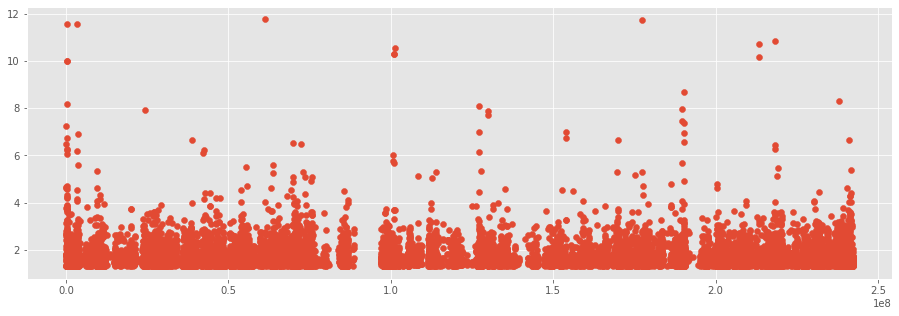

In [454]:
fig1, axs1 = plt.subplots(1)

axs1.scatter(filtered.loc[filtered['#CHROM'] == 2]['POS'],- np.log10(filtered.loc[filtered['#CHROM'] == 2]['pvalue']))
plt.rcParams["figure.figsize"] = [ 5,15.50]


#  prepare dataframe


## read data

In [3]:
dir_path  = '.'
lists = []
for file in os.listdir(dir_path):
    if file.endswith('.csv'):
        lists.append(file)     
lists.sort()
lists = [x.split('.')[0] for x in lists]

In [163]:
len(set(molecular_trait_object_id_idx))

33267

In [162]:
len(set(molecular_trait_object_id))

33267

In [4]:
float_lists = [x for x in lists if x.find('idx') == -1]
string_lists = [x for x in lists if x.find('idx') != -1]

In [5]:
for name in (string_lists):
    locals()[f'{name}'] = np.loadtxt(name + '.csv', delimiter= '\t',dtype='str')

In [6]:
for name in (float_lists):
    locals()[f'{name}'] = np.loadtxt(name + '.csv', delimiter= '\t')
    print(name + ' done')

beta done
gene_id done
molecular_trait_id done
molecular_trait_object_id done
pvalue done
rsid done
se done
study done
variant done


In [7]:
len(variant)==len(pvalue)==len(beta)==len(rsid)==len(molecular_trait_object_id)==len(beta)==len(se)==len(molecular_trait_id)==len(gene_id)

True

In [7]:
def remap_columns(df):
    
    ''' remaps the columns to their original values, removes the column variant, renames the column pvalue to BETA '''
    
    df["variant"]=df["variant"].apply(lambda x: variant_idx[int(x)])
    df["ID"]=df['ID'].apply(lambda x:rsid_idx[int(x)])
    df['POS']=df['variant'].apply(lambda x: x.split('_')[1])
    df['REF']=df['variant'].apply(lambda x: x.split('_')[2])
    df['ALT']=df['variant'].apply(lambda x: x.split('_')[3])
    df['#CHROM']=df['variant'].apply(lambda x:int(re.search(r'\d+',x.split('_')[0]).group()))
    df=df.drop(['variant'], axis=1 )
    df=df.rename(columns= {'pvalue':'BETA'})

    return(df)

In [8]:
def drop_duplicated_variants(df):
    
    ''' drops variants that comes from different studies, variants that have different alternatives but same rsids,
              and variants that have same postion reference and alternative, but different rsid. 
    returns df with dropped duplicated variants, and the number of SNPs that have switched REF and ALT and their Pos '''
    
    # drop variants that comes from different studies 
    df=df.drop_duplicates(subset=['ID','POS','REF','ALT','#CHROM']).reset_index(drop =True)  
    
    # drop variants that have different alternatives
    df=df.drop_duplicates(subset=['ID','POS','REF','#CHROM']).reset_index(drop =True) 
    
    # drop variants that have same postion and alternative, but different ID
    df=df.drop_duplicates(subset=['POS','REF','ALT','#CHROM']).reset_index(drop =True)
    
    #check everithing is unique 
    q = df.groupby(['#CHROM','POS']).size().reset_index(name='Freq').sort_values(by='Freq',ascending=False)
    print ("we have " + str(len(q.loc[q.Freq == 2].POS)) + " variants that have switched REF and ALT")
    
    return(df, q.loc[q.Freq > 1].POS)

In [9]:
def rename_columns(df):
    df= df.rename(columns= {"#CHROM":'chr_name',
                            "POS":"chr_position",
                            "ALT":"effect_allele", 
                            "REF":"other_allele",
                            "BETA":"effect_weight"})
    return(df)

In [10]:
def rename_columns_again(df):
    df= df.rename(columns= {"chr_name":"#CHROM",
                            "chr_position":"POS",
                            "effect_allele":"ALT", 
                            "other_allele":"REF",
                            "effect_weight":"BETA"})
    return(df)

## Sumstats

In [7]:
sumstats = pd.DataFrame({"variant":variant,
                         "beta":beta,
                         "ID":rsid,
                         "pvalue":pvalue,
                         "se":se})

In [9]:
sumstats = sumstats.sort_values(by="pvalue").reset_index(drop=True)

In [19]:
sumstats

,variant,beta,ID,pvalue,se
0,279553.0,1.216870,2295193.0,8.257220e-249,0.022591
1,1001447.0,1.216870,1442385.0,8.257220e-249,0.022591
2,963422.0,1.216870,2259402.0,8.257220e-249,0.022591
3,2365852.0,1.216870,719107.0,8.257220e-249,0.022591
4,1399668.0,1.216870,2034437.0,8.257220e-249,0.022591
...,...,...,...,...,...
694032611,12301770.0,0.559676,12085153.0,4.999980e-03,0.198430
694032664,13642884.0,2.137290,13490391.0,4.999990e-03,0.739216
694032750,14117191.0,-0.848850,14020308.0,4.999990e-03,0.300929
694032856,12880470.0,-0.718601,12777301.0,4.999990e-03,0.253782


In [15]:
sumstats = sumstats.drop_duplicates(['variant','ID'])

In [20]:
sumstats = sumstats.reset_index(drop=True)

In [24]:
sumstats = remap_columns(sumstats)

In [29]:
sumstats, pos = drop_duplicated_variants(sumstats)

we have 3014 variants that have switched REF and ALT


In [30]:
sumstats= sumstats.rename(columns= {"#CHROM":"chr",
                            "POS":"pb_hg38",
                            "ALT":"effect_allele", 
                            "REF":"noneffect_allele",
                            "se":"se_dgc",
                            "ID":"markername",
                            "pvalue":"p_dgc"})

In [423]:
variant_idx[279553]

'chr17_19675560_A_T'

In [31]:
sumstats

,beta,markername,BETA,se_dgc,pb_hg38,noneffect_allele,effect_allele,chr
0,1.216870,rs7216,8.257220e-249,0.022591,19675560,A,T,17
1,1.216870,rs8069576,8.257220e-249,0.022591,19667007,A,G,17
2,1.216870,rs2108971,8.257220e-249,0.022591,19662632,G,A,17
3,1.216870,rs2386145,8.257220e-249,0.022591,19659705,C,G,17
4,1.216870,rs962800,8.257220e-249,0.022591,19656155,A,G,17
...,...,...,...,...,...,...,...,...
14589653,0.559676,rs115570110,4.999980e-03,0.198430,91820375,A,G,12
14589654,2.137290,rs149024095,4.999990e-03,0.739216,67891077,G,A,7
14589655,-0.848850,rs73085891,4.999990e-03,0.300929,13135361,A,G,20
14589656,-0.718601,rs187383325,4.999990e-03,0.253782,89947999,G,T,7


In [103]:
sumstats = sumstats[['markername','chr','pb_hg38','noneffect_allele','effect_allele','beta','se_dgc','p_dgc']]


In [105]:
sumstats.to_csv('sunstats.txt',sep ='\t', index = False )

## DF

In [160]:
df = pd.DataFrame({"variant":variant,
                   "trait_ID":molecular_trait_object_id,
                   "transkript_ID":molecular_trait_id,
                   "gene_ID":gene_id,
                   "beta":beta,
                   "ID":rsid,
                   "pvalue":pvalue})

In [214]:
df = df.sort_values(by="pvalue").reset_index(drop=True)

In [24]:
df["variant"]=df["variant"].apply(lambda x: variant_idx[int(x)])


In [26]:
df["ID"]=df['ID'].apply(lambda x:rsid_idx[int(x)])

In [164]:
len(df.trait_ID.unique())

33267

In [142]:
df = df.drop_duplicates(['variant','ID'])

In [16]:
variants_path = '/dh-projects/uk_bb_intergenics/analysis/development/upmeiejv/results/gwas-general/pvar_externded_ids.tsv'

In [17]:
variants=pd.read_csv(variants_path,sep='\t',usecols= ['ID','id'])

In [22]:
variants['id'] = variants['id'].apply(lambda x:x.replace(":", "_"))


In [23]:
variants 

,ID,id
0,rs367896724,1_10177_AC_A
1,rs540431307,1_10235_TA_T
2,rs201106462,1_10352_TA_T
3,rs548419688,1_10505_T_A
4,rs568405545,1_10506_G_C
...,...,...
93095618,rs546768261,22_51241342_A_C
93095619,rs568168135,22_51241386_G_C
93095620,rs199560686,22_51244163_G_A
93095621,rs556942236,22_51244205_T_C


# best 100k pvalues:

best 100k pvalues from the 700 Mio SNPs (all studies and tissues) no maximum number of variants per gene, drop all duplicates of SNPs that occur in differnet studies or have different traits and only leave the ones with the smaller p value

In [50]:
top_p_val = df.head(2000_000).copy()#.drop(['Gene_ID', 'beta'], axis=1 ).drop_duplicates()

In [51]:
top_p_val = remap_columns(top_p_val).drop_duplicates()

In [52]:
top_p_val, pos = drop_duplicated_variants(top_p_val)

we have 1 variants that have switched REF and ALT


In [53]:
top_p_val.loc[top_p_val.POS.isin(pos.tolist())]

,Gene_ID,beta,ID,BETA,se,POS,REF,ALT,#CHROM
45908,15683.0,1.561880,rs374740253,2.432320e-74,0.068619,43622705,G,GT,7
161964,15683.0,0.872446,rs796806638,3.982910e-42,0.052902,43622705,GT,G,7


In [54]:
# check reference genom, correct variants that have reversed ALT and REF, drop ones with larger pvalue

#CHROM	POS	ID	REF	ALT	BETA
#7	43622705	rs374740253	G	GT	2.432320e-74
#7	43622705	rs796806638	GT	G	3.982910e-42

top_p_val = top_p_val.drop(top_p_val[(top_p_val['#CHROM']==7)&(top_p_val.POS=='43622705')&(top_p_val.REF=='GT')].index)


In [48]:
top_p_val['BETA'] = -np.log10(top_p_val['BETA'])

In [177]:
! mkdir dataset_top_100k_pval

In [169]:
top_p_val.head(100_000).to_csv('/dh-projects/uk_bb_intergenics/analysis/development/aboughas/results/dataset_top_100k_pval/subsets_pgs/variant_subset.100k.tsv', 
                             sep ='\t', index = False )

In [168]:
top_p_val=top_p_val[['#CHROM','POS','ID','REF','ALT','BETA']]

In [56]:
top_p_val=rename_columns(top_p_val)

In [171]:
top_p_val.head(100_000).to_csv('dataset_top_100k_pval/dataset_top_100k_pval.txt', index = False )

In [37]:
len(top_p_val.head(100_000).Gene_ID.unique())

1814

In [57]:
top_p_val

,Gene_ID,beta,ID,effect_weight,se,chr_position,other_allele,effect_allele,chr_name
0,7889.0,1.216870,rs7216,8.257220e-249,0.022591,19675560,A,T,17
1,7889.0,1.216870,rs8069576,8.257220e-249,0.022591,19667007,A,G,17
2,7889.0,1.216870,rs2108971,8.257220e-249,0.022591,19662632,G,A,17
3,7889.0,1.216870,rs2386145,8.257220e-249,0.022591,19659705,C,G,17
4,7889.0,1.216870,rs962800,8.257220e-249,0.022591,19656155,A,G,17
...,...,...,...,...,...,...,...,...,...
167525,12344.0,0.692141,rs6815884,2.743060e-41,0.047298,20671271,T,G,4
167526,14530.0,1.291380,rs3756402,2.745600e-41,0.082113,69368688,C,T,5
167527,16714.0,0.732626,rs150979693,2.749180e-41,0.050271,60842904,C,CGTAGGGCA,5
167528,16714.0,0.732626,rs34741733,2.749180e-41,0.050271,60843721,C,T,5


# common SNPs in different tissues, studies and traits



In [65]:
# p_threshold 4.569940e-05 (top 100Mio)
best_100_mio = df.head(100_000_000).copy()

In [66]:
best_100_mio = remap_columns(best_100_mio)

In [67]:
most_commom=best_100_mio.groupby(['#CHROM','POS','ALT','REF','ID']).size().reset_index(name='Freq').sort_values(by='Freq',ascending=False)

In [68]:
most_commom

,#CHROM,POS,ALT,REF,ID,Freq
4076342,17,45680084,A,C,rs55974014,1586
4077394,17,45837192,A,G,rs10445363,1581
4079407,17,46119287,A,G,rs75229280,1579
4079343,17,46109528,C,A,rs62061822,1578
4076725,17,45728159,C,A,rs62054387,1578
...,...,...,...,...,...,...
1111463,3,98374395,A,C,rs79610940,1
1111464,3,98374556,T,C,rs114476714,1
1111465,3,98374792,A,T,rs62268318,1
1111466,3,98374861,C,T,rs13093620,1


In [69]:
most_common=most_commom.reset_index(drop=True)

In [70]:
# drop variants that have different alternative

most_common = most_common.drop_duplicates(subset=['ID', 'POS', 'REF', '#CHROM']).reset_index(drop =True)

In [71]:
# drop variants that have same postion and alternative, but different ID, take the one with smaller pvalue 

most_common=most_common.drop_duplicates(subset=['POS', 'REF', 'ALT', '#CHROM']).reset_index(drop =True) 

In [72]:
most_common = most_common.rename(columns= {'Freq' : 'BETA'})

In [73]:
most_common = most_common[['#CHROM'  ,'POS' ,'ID'  , 'REF' ,    'ALT',     'BETA']]

In [58]:
most_common.head(100_000)

,chr_name,chr_position,effect_allele,other_allele,ID,effect_weight
0,17,45680084,A,C,rs55974014,1586
1,17,45837192,A,G,rs10445363,1581
2,17,46119287,A,G,rs75229280,1579
3,17,46109528,C,A,rs62061822,1578
4,17,45728159,C,A,rs62054387,1578
...,...,...,...,...,...,...
99995,3,138352487,A,T,rs1564408,205
99996,14,24030793,G,C,rs74578053,205
99997,3,138604740,C,T,rs587005,205
99998,3,138355159,C,G,rs6439807,205


In [60]:
path_to_subsets_pgs = '/dh-projects/uk_bb_intergenics/analysis/development/aboughas/results/dataset_most_common/subsets_pgs'

In [62]:
most_common.head(100_000).to_csv(path_to_subsets_pgs +'/variant_subset.100k.tsv', 
                             sep ='\t', index = False )

In [74]:
most_common= rename_columns(most_common)

In [66]:
most_common.head(100_000).to_csv('dataset_most_common/dataset_most_common.txt',  index = False)

#  random selection

In [69]:
r = np.arange(0, 694033553, 1, dtype=int)
np.random.shuffle(r)

In [70]:
another_random_2M = df.filter(items =(r[:2000_000]), axis=0).copy().reset_index(drop =True) 

In [71]:
another_random_2M = remap_columns(another_random_2M)

In [73]:
# drop variants that comes from different studies 
another_random_2M=another_random_2M.drop_duplicates(subset=['ID','POS','REF','ALT','#CHROM']).reset_index(drop =True) 

In [79]:
another_random_2M

,Gene_ID,beta,ID,BETA,POS,REF,ALT,#CHROM
0,14057.0,-1.196160,rs262852,3.715150e-05,169742303,C,T,5
1,1269.0,-0.369047,rs56090579,1.913870e-04,50062736,T,C,10
2,10798.0,-0.418433,rs190700864,4.135820e-03,113828053,T,A,13
3,12178.0,0.364874,rs2431318,1.361230e-03,102782375,C,T,5
4,10329.0,-0.355668,rs687654,3.429760e-07,125071626,C,T,9
...,...,...,...,...,...,...,...,...
1507928,4415.0,-0.204081,rs816864,3.337730e-03,77554812,C,T,10
1507929,11953.0,0.599251,rs348385,6.170250e-04,6553455,G,T,19
1507930,13063.0,-0.284056,rs10176171,3.759080e-03,101451415,C,T,2
1507931,2432.0,0.274371,rs7494544,2.334000e-03,100566370,A,G,14


In [76]:
# drop variants that have different alternatives

another_random_2M = another_random_2M.drop_duplicates(subset=['ID', 'POS', 'REF', '#CHROM']).reset_index(drop =True) 

In [77]:
# drop variants that have same postion and alternative, but different ID

another_random_2M = another_random_2M.drop_duplicates(subset=['POS', 'REF', 'ALT', '#CHROM']).reset_index(drop =True)

In [85]:
another_random_2M.head(100_000).groupby(['Gene_ID']).sum()

,beta,BETA,#CHROM
Gene_ID,,,
1.0,1.069552,0.006383,6
2.0,2.211384,0.019711,45
3.0,-2.851435,0.028863,504
4.0,-0.211389,0.050633,42
6.0,1.590322,0.007821,24
...,...,...,...
33076.0,-0.424023,0.000450,18
33077.0,-0.549127,0.001161,11
33112.0,-0.920120,0.001147,12


In [82]:
len(q.loc[q.Freq == 2].POS)

22

In [81]:
another_random_2Mio = another_random_2Mio.rename(columns= {'pvalue' : 'BETA'})

In [82]:
another_random_2Mio = another_random_2Mio[['#CHROM'  ,'POS' ,'ID'  , 'REF' ,    'ALT',  'BETA']]

In [91]:
rng = default_rng()
numbers = rng.choice(2000_000, size=len(another_random_2Mio.BETA), replace=False)/1000

In [92]:
another_random_2Mio.BETA = numbers 

In [94]:
subsets_pgs_path='/dh-projects/uk_bb_intergenics/analysis/development/aboughas/results/dataset_random_select2/subsets_pgs/'
another_random_2Mio.head(100_000).to_csv(subsets_pgs_path + 'variant_subset.100k.tsv', sep ='\t', index = False )

In [95]:
another_random_2Mio= another_random_2Mio.rename(columns= {"#CHROM" : 'chr_name',
                                  "POS": "chr_position",
                                  "ALT" :"effect_allele", 
                                  "REF": "other_allele",
                                  "BETA":"effect_weight"})

In [96]:
another_random_2Mio.head(100_000).to_csv('dataset_random_select/dataset_random_select2.txt', index = False )

In [ ]:
###########################################################################################################################

In [97]:
random_2Mio = df.sample(n=2000_000).copy()

In [28]:
random_2Mio["variant"]=random_2Mio["variant"].apply(lambda x:variant_idx[int(x)])
random_2Mio["ID"]=random_2Mio['ID'].apply(lambda x:rsid_idx[int(x)]) 

In [29]:
random_2Mio['POS']=random_2Mio['variant'].apply(lambda x: x.split('_')[1])
random_2Mio['REF']=random_2Mio['variant'].apply(lambda x: x.split('_')[2])
random_2Mio['ALT']=random_2Mio['variant'].apply(lambda x: x.split('_')[3])
random_2Mio['#CHROM']=random_2Mio['variant'].apply(lambda x:int(re.search(r'\d+',x.split('_')[0]).group()))

In [30]:
random_2Mio = random_2Mio.drop(['variant'], axis=1 )

In [31]:
# drop variants that comes from different studies 

random_2Mio = random_2Mio.drop_duplicates(subset=['ID', 'POS', 'REF', 'ALT', '#CHROM']).reset_index(drop =True) 

In [32]:
# drop variants that have different alternatives

random_2Mio = random_2Mio.drop_duplicates(subset=['ID', 'POS', 'REF', '#CHROM']).reset_index(drop =True) 

In [33]:
# drop variants that have same postion and alternative, but different ID

random_2Mio = random_2Mio.drop_duplicates(subset=['POS', 'REF', 'ALT', '#CHROM']).reset_index(drop =True)

In [39]:
random_2Mio.loc[random_2Mio.POS == '73691859']

,beta,ID,pvalue,POS,REF,ALT,#CHROM
1463816,1.15395,rs55784670,8.257140e-23,73691859,G,A,7


In [35]:
q = random_2Mio.groupby(['#CHROM','POS']).size().reset_index(name='Freq').sort_values(by= 'Freq', ascending = False)

In [36]:
len(q.loc[q.Freq == 2].POS)
# we have 19 snps that share pos, ref and chrom, but have differnet ID and ALT

24

In [24]:
q

,#CHROM,POS,Freq
1062380,14,73691854,2
657982,8,116485113,2
1233403,17,42791962,2
239639,3,10183720,2
804389,10,73392394,2
...,...,...,...
502813,6,26833678,1
502812,6,26832907,1
502811,6,2683288,1
502810,6,26831681,1


In [96]:
random_2Mio = random_2Mio.rename(columns= {'pvalue' : 'BETA'})

In [97]:
random_2Mio = random_2Mio[['#CHROM'  ,'POS' ,'ID'  , 'REF' ,    'ALT',  'BETA']]

In [109]:
from numpy.random import default_rng
rng = default_rng()
numbers = rng.choice(2000_000, size=1508572, replace=False)

In [119]:
random_2Mio.BETA = numbers 

In [125]:
random_2Mio.head(100_000).to_csv('/dh-projects/uk_bb_intergenics/analysis/development/aboughas/results/dataset_random_select/subsets_pgs/variant_subset.100k.tsv', 
                             sep ='\t', index = False )

In [126]:
random_2Mio= random_2Mio.rename(columns= {"#CHROM" : 'chr_name',
                                  "POS": "chr_position",
                                  "ALT" :"effect_allele", 
                                  "REF": "other_allele",
                                  "BETA":"effect_weight"})

In [127]:
random_2Mio.head(100_000).to_csv('dataset_random_select/dataset_random_select.txt', index = False )

# another random approach (from all possible SNPs)

In [2]:
# len of pvar_externded_ids: 93095624

r2 = np.arange(2, 93095624, 1, dtype=int)
np.random.shuffle(r2)
skip_list = r2[110_000:]

In [3]:
# all existing SNPs
all_snps_path='/dh-projects/uk_bb_intergenics/analysis/development/upmeiejv/results/gwas-general/pvar_externded_ids.tsv'
all_snps = pd.read_csv(all_snps_path, sep = '\t', skiprows = skip_list)

In [4]:
all_snps = all_snps.loc[all_snps['ID'].str.contains("rs")]

In [5]:
all_snps = all_snps.reset_index(drop =True) 

In [6]:
all_snps=all_snps.drop(['id','flipped_id'], axis=1 )

In [7]:
rng = default_rng()
numbers = rng.choice(2000_000, size=len(all_snps['POS']), replace=False)/10000

In [8]:
all_snps['BETA'] = numbers


In [15]:
all_snps = shuffle(all_snps)
all_snps

,#CHROM,POS,ID,REF,ALT,BETA
55847,8,110754156,rs186334649,C,T,196.5973
60249,9,102888723,rs552421229,T,C,12.6553
101885,21,35503968,rs547636701,T,C,74.6655
79642,13,91292828,rs532852450,A,G,103.3924
80546,13,114809144,rs139020177,G,C,72.9780
...,...,...,...,...,...,...
51192,7,151200225,rs544808464,C,T,91.7759
9858,2,38038720,rs376521234,C,T,58.3036
71699,11,125254123,rs769318821,A,G,190.6036
28166,4,79265633,rs376907161,C,G,103.6939


In [16]:
subsets_pgs_path='/dh-projects/uk_bb_intergenics/analysis/development/aboughas/results/dataset_random_select_all_snps/subsets_pgs/'
all_snps.head(100_000).to_csv(subsets_pgs_path + 'variant_subset.100k.tsv', sep ='\t', index = False )

In [21]:
all_snps = rename_columns(all_snps)

In [22]:
all_snps.head(100_000).to_csv('dataset_random_select/dataset_random_select_all_snps.txt', index = False )

# different traits (genes)

## all traits: 3-4 variants per trait 

In [215]:
grouped = df.groupby(by=["trait_ID"])

In [243]:
merged = pd.merge(grouped.head(3), grouped.head(4), how='outer', indicator= True)

In [244]:
print("number of differint genes:\n"+str(len(merged.head(100_000).trait_ID.unique()))) 

number of differint genes:
33267


In [245]:
merged = remap_columns(merged)

In [246]:
merged,pos = drop_duplicated_variants(merged)

we have 1 variants that have switched REF and ALT


In [247]:
merged.loc[merged.POS.isin(pos.tolist())]


,trait_ID,transkript_ID,gene_ID,beta,ID,BETA,_merge,POS,REF,ALT,#CHROM
91691,31186.0,171892.0,31076.0,0.685352,rs56204042,0.000420,both,54614176,A,AT,7
94014,30124.0,169751.0,30237.0,0.610272,rs5023174,0.001298,both,54614176,A,T,7


In [248]:
print("number of remaining affected genes:\n"+str(len(merged.head(100_000).trait_ID.unique()))) 

number of remaining differint genes:
33191


In [250]:
merged = merged[['#CHROM','POS','ID','REF','ALT','BETA']]

In [249]:
len(set(merged.ID)) == len((merged.ID))

True

In [251]:
merged['BETA'] = -np.log10(merged['BETA'])

In [109]:
path_to_subsets_pgs = '/dh-projects/uk_bb_intergenics/analysis/development/aboughas/results/dataset_all_genes_top_pval/subsets_pgs'

In [111]:
merged.head(100_000).to_csv(path_to_subsets_pgs +'/variant_subset.100k.tsv', 
                             sep ='\t', index = False )

In [89]:
merged = rename_columns(merged)

In [114]:
merged.head(100_000).to_csv('dataset_different_genes/dataset_all_genes_top_pval.txt',  index = False)

In [115]:
np.sort(merged.head(100_000).chr_name.unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22])

## all traits in the first 70Mio: 7 variants per Gene

In [149]:
top_70Mio = df.head(70_000_000).groupby(by=["Gene_ID"])

In [150]:
top_70Mio = top_70Mio.head(7)

In [151]:
print("number of differint genes:\n"+str(len(top_70Mio.head(100_000).Gene_ID.unique()))) 

number of differint genes:
15891


In [152]:
top_70Mio = remap_columns(top_70Mio)

In [153]:
top_70Mio, pos = drop_duplicated_variants(top_70Mio)

we have 0 variants that have switched REF and ALT


In [154]:
top_70Mio = top_70Mio.drop(['Gene_ID', 'beta'], axis=1 )


In [155]:
top_70Mio = top_70Mio[['#CHROM','POS','ID','REF','ALT','BETA']]

In [70]:
top_70Mio.BETA =  -np.log10(top_70Mio.BETA)

In [146]:
! mkdir dataset_different_genes

In [182]:
top_70Mio.head(100_000).to_csv('/dh-projects/uk_bb_intergenics/analysis/development/aboughas/results/dataset_different_genes/subsets_pgs/variant_subset.100k.tsv', 
                             sep ='\t', index = False )

In [156]:
top_70Mio=rename_columns(top_70Mio)

In [104]:
top_15k_genes = top_70Mio.head(100)

In [188]:
np.sort(top_70Mio.head(100_000).chr_name.unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22])

In [187]:
top_70Mio.head(100_000).to_csv('dataset_different_genes/dataset_different_genes.txt', index = False )

# Snps mapped to different genes

In [11]:
dif_genes_path='/dh-projects/uk_bb_intergenics/analysis/development/aboughas/results/dataset_all_eqtls/annotated_df/snpeff_df.100k.txt'

In [12]:
dif_genes = pd.read_csv(dif_genes_path)

In [13]:
len(dif_genes.ANN_Gene_ID.unique())

69571

In [14]:
dif_genes= dif_genes.sort_values(by="SCORE").reset_index(drop=True)

In [15]:
dif_genes = dif_genes[['ANN_Gene_ID','ID','CHROM','POS','REF','ALT','SCORE']]

In [55]:
dif_genes

,ANN_Gene_ID,ID,CHROM,POS,REF,ALT,SCORE
0,ENSG00000238458,rs1886248,6,18399163,C,T,1.695040e-153
1,ENSG00000147408,rs10888163,8,19457523,G,T,3.159620e-137
2,ENSG00000238458,rs7771828,6,18398104,T,G,1.002930e-121
3,ENSG00000147408,rs4625053,8,19459759,A,G,2.922060e-113
4,ENSG00000181995,rs950802,11,60385111,G,A,1.906370e-112
...,...,...,...,...,...,...,...
14740094,ENSG00000233217,rs4915463,1,200910174,A,G,4.999990e-03
14740095,ENSG00000232053,rs12334035,7,135886998,T,C,4.999990e-03
14740096,ENSG00000226684-ENSG00000224849,rs12206087,6,98135024,G,A,4.999990e-03
14740097,ENSG00000214050,rs78525589,8,28334367,C,T,4.999990e-03


In [18]:
grouped_dif_genes = dif_genes.groupby(by=["ANN_Gene_ID"])

In [19]:
merged_dif_genes = pd.merge(grouped_dif_genes.head(1), grouped_dif_genes.head(2), 
                            how='outer', indicator= True).reset_index(drop=True)

In [21]:
len(set(merged_dif_genes.head(100_000).ANN_Gene_ID))

69570

In [22]:
merged_dif_genes = merged_dif_genes.rename(columns= {"CHROM":'#CHROM',
                                            'SCORE':'BETA'})

In [23]:
merged_dif_genes = merged_dif_genes.drop(['ANN_Gene_ID', '_merge'], axis =1)

In [24]:
merged_dif_genes, pos= drop_duplicated_variants(merged_dif_genes)

we have 1 variants that have switched REF and ALT


In [28]:
merged_dif_genes

,ID,#CHROM,POS,REF,ALT,BETA
0,rs1886248,6,18399163,C,T,1.695040e-153
1,rs10888163,8,19457523,G,T,3.159620e-137
2,rs950802,11,60385111,G,A,1.906370e-112
3,rs150892208,5,71044045,G,T,1.794670e-106
4,rs12977007,19,52386757,G,A,1.140540e-103
...,...,...,...,...,...,...
138472,rs117003805,22,20951558,A,G,4.979630e-03
138473,rs141208928,1,188473491,G,A,4.985430e-03
138474,rs13396604,2,209092453,G,C,4.998480e-03
138475,rs543948546,10,46945044,C,T,4.998510e-03


In [68]:
hs = pd.read_csv('Homo_sapiens.csv')

/tmp/ipykernel_3837350/750875997.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  hs = pd.read_csv('Homo_sapiens.csv')


In [106]:
hs = hs.drop(['transcript_support_level'], axis =1)

In [121]:
hs

,seqname,feature,start,end,score,strand,frame,gene_id,gene_source,gene_biotype,transcript_id,transcript_biotype,ccds_id,exon_number,exon_id,protein_id
0,1,gene,1471765,1497848,NaN,+,0,ENSG00000160072,ensembl_havana,protein_coding,NaN,NaN,NaN,NaN,NaN,NaN
1,1,transcript,1471765,1497848,NaN,+,0,ENSG00000160072,ensembl_havana,protein_coding,ENST00000673477,protein_coding,CCDS30,NaN,NaN,NaN
2,1,exon,1471765,1472089,NaN,+,0,ENSG00000160072,ensembl_havana,protein_coding,ENST00000673477,protein_coding,CCDS30,1.0,ENSE00003889014,NaN
3,1,CDS,1471885,1472089,NaN,+,0,ENSG00000160072,ensembl_havana,protein_coding,ENST00000673477,protein_coding,CCDS30,1.0,NaN,ENSP00000500094
4,1,start_codon,1471885,1471887,NaN,+,0,ENSG00000160072,ensembl_havana,protein_coding,ENST00000673477,protein_coding,CCDS30,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3409301,KI270713.1,five_prime_utr,32373,32528,NaN,-,0,ENSG00000277475,ensembl,protein_coding,ENST00000612315,protein_coding,NaN,NaN,NaN,NaN
3409302,KI270713.1,three_prime_utr,31698,31841,NaN,-,0,ENSG00000277475,ensembl,protein_coding,ENST00000612315,protein_coding,NaN,NaN,NaN,NaN
3409303,KI270713.1,gene,21861,22024,NaN,-,0,ENSG00000275405,ensembl,snRNA,NaN,NaN,NaN,NaN,NaN,NaN
3409304,KI270713.1,transcript,21861,22024,NaN,-,0,ENSG00000275405,ensembl,snRNA,ENST00000619109,snRNA,NaN,NaN,NaN,NaN


In [56]:
merged_dif_genes

,#CHROM,POS,ID,REF,ALT,BETA
0,6,18399163,rs1886248,C,T,152.770820
1,8,19457523,rs10888163,G,T,136.500365
2,11,60385111,rs950802,G,A,111.719793
3,5,71044045,rs150892208,G,T,105.746015
4,19,52386757,rs12977007,G,A,102.942889
...,...,...,...,...,...,...
138472,22,20951558,rs117003805,A,G,2.302803
138473,1,188473491,rs141208928,G,A,2.302297
138474,2,209092453,rs13396604,G,C,2.301162
138475,10,46945044,rs543948546,C,T,2.301159


In [39]:
merged_dif_genes = merged_dif_genes[['#CHROM','POS','ID','REF','ALT','BETA']]

In [44]:
merged_dif_genes['BETA'] = -np.log10(merged_dif_genes['BETA'] )

In [50]:
path='/dh-projects/uk_bb_intergenics/analysis/development/aboughas/results/dataset_snps_mapped_to_all_genes/subsets_pgs/variant_subset.100k.tsv'

In [57]:
merged_dif_genes.head(100_000).to_csv(path,sep ='\t', index = False )

In [52]:
merged_dif_genes=rename_columns_again(merged_dif_genes)

In [48]:
!mkdir dataset_snps_mapped_to_all_genes

In [49]:
merged_dif_genes.head(100_000).to_csv('dataset_snps_mapped_to_all_genes/dataset_snps_mapped_to_all_genes.txt',sep ='\t',  index = False )

# best betas

In [115]:
df['beta'] = np.absolute(df['beta'])

In [116]:
df_beta_sorted = df.sort_values(by="beta").reset_index(drop=True)

In [532]:
df_beta_sorted.tail(10)
# scatterplot beta and pvlaue 

,variant,Gene_ID,beta,ID,pvalue
694033544,10202479.0,21863.0,18.8316,10141180.0,0.001433
694033545,10109848.0,23524.0,19.3175,10032466.0,0.000744
694033546,10257281.0,3635.0,19.5042,10207876.0,0.004938
694033547,10109848.0,6226.0,19.5511,10032466.0,0.000631
694033548,10250746.0,1501.0,19.6020,10057382.0,0.000015
694033549,10236112.0,19484.0,19.6164,10169362.0,0.000177
694033550,4558975.0,13766.0,20.7449,3236101.0,0.001904
694033551,10236112.0,775.0,21.4116,10169362.0,0.000140
694033552,9956391.0,13331.0,25.6489,9913961.0,0.000929
694033553,10132228.0,15246.0,28.7586,10037897.0,0.001935


In [117]:
top_beta = df_beta_sorted.tail(2000_000).copy()

In [118]:
top_beta = remap_columns(top_beta)

In [119]:
top_beta, pos = drop_duplicated_variants(top_beta)

we have 12 variants that have switched REF and ALT


In [428]:
top_beta['REF'][270554] = 'A'
top_beta['ALT'][270554] = 'AACAC'

/tmp/ipykernel_134239/2614499507.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_beta['REF'][270554] = 'A'
/tmp/ipykernel_134239/2614499507.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_beta['ALT'][270554] = 'AACAC'


In [419]:
top_beta.loc[top_beta.POS.isin(pos.tolist())].sort_values(by="POS")

,Gene_ID,beta,ID,BETA,POS,REF,ALT,#CHROM
349208,26213.0,3.02471,rs769885046,0.000203,12337211,C,CTTT,19
411853,12941.0,3.04691,rs28652928,0.000559,12337211,C,T,19
911024,1141.0,3.53783,rs75024830,0.001323,131365867,A,T,2
82605,5818.0,2.95453,rs545636785,0.000017,131365867,A,AAAAT,2
675144,14755.0,3.18633,rs576823123,0.000137,159597872,G,GC,4
914182,8569.0,3.54840,rs181625182,0.001948,159597872,G,C,4
982263,2466.0,3.98302,rs79827022,0.000001,190392059,C,T,3
659296,2466.0,3.17381,rs773582120,0.001485,190392059,C,CTTTTTTTTTTTTTTT,3
742639,9415.0,3.24478,rs529135365,0.004853,220454842,AAAC,A,2
989702,7979.0,4.08245,rs369541650,0.002979,220454842,A,AAAC,2


In [420]:
print ("SNPs are mapped to " + str(len(top_beta.tail(100_000).Gene_ID.unique())) + " differnt genes")

SNPs are mapped to 14987 differnt genes


In [429]:
top_beta=top_beta.drop(['BETA'], axis=1 )

In [430]:
top_beta=top_beta.rename(columns= {'beta':'BETA'})

In [91]:
top_beta=top_beta[['#CHROM','POS','ID','REF','ALT','BETA']]

In [431]:
top_beta=top_beta.sort_values(by="BETA", ascending=False)


In [95]:
top_beta.head(100_000).to_csv('/dh-projects/uk_bb_intergenics/analysis/development/aboughas/results/dataset_top_beta/subsets_pgs/variant_subset.100k.tsv', 
                             sep ='\t', index = False )


In [122]:
top_beta=rename_columns(top_beta)

In [97]:
top_beta.head(100_000).to_csv('dataset_top_beta/dataset_top_beta.txt', index = False )

In [121]:
top_beta.loc[top_beta.effect_weight<3]

,Gene_ID,beta,ID,effect_weight,se,chr_position,other_allele,effect_allele,chr_name
0,18469.0,2.9388,rs73292459,0.004859,1.009360,44022089,T,A,20
1,13288.0,2.9388,rs190549169,0.000616,0.821985,74204752,C,T,14
2,8439.0,2.9388,rs8018907,0.003595,0.961685,44149148,T,C,14
3,14294.0,2.9388,rs149106162,0.002373,0.933206,157359916,C,T,7
4,18739.0,2.9388,rs141208132,0.002025,0.917933,882042,T,TA,17
...,...,...,...,...,...,...,...,...,...
1041286,12489.0,15.9806,rs181362303,0.002347,5.071080,70385638,G,A,15
1041287,1920.0,16.5809,rs1519193,0.002841,5.370440,140907875,C,T,3
1041288,3635.0,19.5042,rs138468712,0.004938,6.730310,121081141,G,T,2
1041289,19484.0,19.6164,rs375979353,0.000177,4.967540,121630061,A,T,4


# LDpred

In [535]:
!ls LDpred/

beta_auto.tsv	     ld_pred.R		 sumstats_chr18.txt  sumstats_chr5.txt
beta_inf.tsv	     sumstats_chr10.txt  sumstats_chr19.txt  sumstats_chr6.txt
core.180399	     sumstats_chr11.txt  sumstats_chr1.txt   sumstats_chr7.txt
core.57268	     sumstats_chr12.txt  sumstats_chr20.txt  sumstats_chr8.txt
core.62033	     sumstats_chr13.txt  sumstats_chr21.txt  sumstats_chr9.txt
core.68195	     sumstats_chr14.txt  sumstats_chr22.txt  sumstats_hg19.txt
core.74071	     sumstats_chr15.txt  sumstats_chr2.txt   sumstats_hg38.txt
LDpred2-Copy1.ipynb  sumstats_chr16.txt  sumstats_chr3.txt
LDpred2.ipynb	     sumstats_chr17.txt  sumstats_chr4.txt


In [536]:
sumstats = pd.read_csv('LDpred/sumstats_hg19.txt', sep='\t')

/tmp/ipykernel_3837350/1613486819.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  sumstats = pd.read_csv('LDpred/sumstats_hg19.txt', sep='\t')


## beta_inf

In [381]:
beta_inf = pd.read_csv('LDpred/beta_inf.tsv',sep='\t', header=None,names = [1,0.3,0.1,0.03,0.01,0.003,0.001])

In [382]:
beta_inf

,1.000,0.300,0.100,0.030,0.010,0.003,0.001
0,1.169635,1.202304,1.211976,1.215398,1.216379,1.216723,1.216821
1,1.169635,1.202304,1.211976,1.215398,1.216379,1.216723,1.216821
2,1.169635,1.202304,1.211976,1.215398,1.216379,1.216723,1.216821
3,1.169635,1.202304,1.211976,1.215398,1.216379,1.216723,1.216821
4,1.169635,1.202304,1.211976,1.215398,1.216379,1.216723,1.216821
...,...,...,...,...,...,...,...
14568117,1.319243,0.944920,0.359152,0.071482,0.014136,0.002330,0.000448
14568118,-0.400948,-0.263739,-0.089609,-0.016955,-0.003320,-0.000546,-0.000105
14568119,-0.690707,-0.458641,-0.157614,-0.029965,-0.005873,-0.000966,-0.000186
14568120,2.054328,1.432017,0.523914,0.102400,0.020177,0.003323,0.000639


In [398]:
sumstats['LD_beta_inf_p_0.001'] = beta_inf[0.001]
sumstats['LD_beta_inf_p_0.1'] = beta_inf[0.1]
sumstats['LD_beta_inf_p_0.01'] = beta_inf[0.01]

In [405]:
sumstats['LD_beta_inf_p_0.1'] = abs(sumstats['LD_beta_inf_p_0.1'])

In [437]:
sumstats['LD_beta_inf_p_0.01'] = abs(sumstats['LD_beta_inf_p_0.01'])

In [469]:
sumstats['LD_beta_inf_p_0.001'] = abs(sumstats['LD_beta_inf_p_0.001'])

In [412]:
sumstats_01 = sumstats.sort_values(by="LD_beta_inf_p_0.1",ascending=False).reset_index(drop=True).head(200_000).copy()

In [416]:
sumstats_01 = sumstats_01.drop(['beta','p_dgc','LD_beta_inf_p_0.01','LD_beta_inf_p_0.001'],axis = 1)

In [420]:
sumstats_01 = sumstats_01.rename(columns= {"chr":"#CHROM",
                                           "pb_hg19":"POS",
                                           "effect_allele":"ALT", 
                                           "noneffect_allele":"REF",
                                           "markername":"ID",
                                           "LD_beta_inf_p_0.1":"BETA"})

In [431]:
sumstats_01 = sumstats_01[['#CHROM','POS','ID','REF','ALT','BETA']]

In [424]:
sumstats_01, pos = drop_duplicated_variants(sumstats_01)

we have 1 variants that have switched REF and ALT


In [430]:
path_LD = '/dh-projects/uk_bb_intergenics/analysis/development/aboughas/results/dataset_LD_inf_01/subsets_pgs/'

In [432]:
sumstats_01.head(100_000).to_csv(path_LD + 'variant_subset.100k.tsv',  sep ='\t', index = False )

In [433]:
sumstats_01 = rename_columns(sumstats_01)

In [434]:
!mkdir LD_Datasets

In [435]:
sumstats_01.head(100_000).to_csv('LD_Datasets/dataset_LD_inf_01.txt', index = False )

In [439]:
sumstats_001 = sumstats.sort_values(by="LD_beta_inf_p_0.01",ascending=False).reset_index(drop=True).head(120_000).copy()

In [441]:
sumstats_001 = sumstats_001.drop(['beta','p_dgc','LD_beta_inf_p_0.1','LD_beta_inf_p_0.001'],axis = 1)

In [455]:
sumstats_001 = sumstats_001.rename(columns= {"chr":"#CHROM",
                                           "pb_hg19":"POS",
                                           "effect_allele":"ALT", 
                                           "noneffect_allele":"REF",
                                           "markername":"ID",
                                           "LD_beta_inf_p_0.01":"BETA"})

In [457]:
sumstats_001 = sumstats_001[['#CHROM','POS','ID','REF','ALT','BETA']]

In [461]:
sumstats_001, pos = drop_duplicated_variants(sumstats_001)

we have 1 variants that have switched REF and ALT


In [460]:
path_LD_001 = '/dh-projects/uk_bb_intergenics/analysis/development/aboughas/results/dataset_LD_inf_001/subsets_pgs/'

In [465]:
sumstats_001.head(100_000).to_csv(path_LD_001 + 'variant_subset.100k.tsv',  sep ='\t', index = False )

In [467]:
sumstats_001 = rename_columns(sumstats_001)

In [468]:
sumstats_001.head(100_000).to_csv('LD_Datasets/dataset_LD_inf_001.txt', index = False )

In [474]:
sumstats_0001 = sumstats.sort_values(by="LD_beta_inf_p_0.001",ascending=False).reset_index(drop=True).head(110_000).copy()

In [477]:
sumstats_0001 = sumstats_0001.drop(['beta','p_dgc','LD_beta_inf_p_0.1','LD_beta_inf_p_0.01'],axis = 1)

In [479]:
sumstats_0001 = sumstats_0001.rename(columns= {"chr":"#CHROM",
                                           "pb_hg19":"POS",
                                           "effect_allele":"ALT", 
                                           "noneffect_allele":"REF",
                                           "markername":"ID",
                                           "LD_beta_inf_p_0.001":"BETA"})

In [481]:
sumstats_0001 = sumstats_0001[['#CHROM','POS','ID','REF','ALT','BETA']]

In [610]:
 sumstats_0001, pos = drop_duplicated_variants(sumstats_0001)

In [483]:
path_LD_0001 = '/dh-projects/uk_bb_intergenics/analysis/development/aboughas/results/dataset_LD_inf_0001/subsets_pgs/'

In [485]:
sumstats_0001.head(100_000).to_csv(path_LD_0001 + 'variant_subset.100k.tsv',  sep ='\t', index = False )

In [486]:
sumstats_0001 = rename_columns(sumstats_0001)

In [487]:
sumstats_0001.head(100_000).to_csv('LD_Datasets/dataset_LD_inf_0001.txt', index = False )

In [608]:
sumstats_0001

,chr_name,chr_position,ID,other_allele,effect_allele,effect_weight
0,17,79164983,rs182307830,G,A,14.243830
1,12,112464290,rs140119108,C,T,13.267339
2,1,160603798,rs115320418,C,T,12.306117
3,17,79100414,rs189994142,G,T,11.660135
4,17,78883132,rs192698184,C,G,11.599533
...,...,...,...,...,...,...
109995,6,30098259,rs5875234,C,CTGAGTA,1.235550
109996,6,30097920,rs9261451,T,G,1.235550
109997,1,244982592,rs9661754,C,T,1.235550
109998,15,31112483,rs798120,A,T,1.235550


## beta auto

In [520]:
beta_auto = pd.read_csv('LDpred/beta_auto.tsv',sep='\t',header=None,names=[1e-04,0.001,0.01,0.1,0.9])

In [538]:
beta_auto

,0.0001,0.0010,0.0100,0.1000,0.9000
0,1.141784,1.141785,1.141785,1.141785,1.141786
1,1.141784,1.141785,1.141785,1.141785,1.141786
2,1.141784,1.141785,1.141785,1.141785,1.141786
3,1.141784,1.141785,1.141785,1.141785,1.141786
4,1.141784,1.141785,1.141785,1.141785,1.141786
...,...,...,...,...,...
14568117,1.287830,1.287831,1.287831,1.287831,1.287832
14568118,-0.391401,-0.391401,-0.391401,-0.391401,-0.391401
14568119,-0.674261,-0.674261,-0.674261,-0.674261,-0.674261
14568120,2.005411,2.005412,2.005412,2.005412,2.005413


In [541]:
sumstats['beta_auto_0.1']= beta_auto[0.1]

In [542]:
sumstats['beta_auto_0.01']= beta_auto[0.01]

In [543]:
sumstats['beta_auto_0.001']= beta_auto[0.001]

In [545]:
sumstats['beta_auto_0.1'] = abs(sumstats['beta_auto_0.1'])
sumstats['beta_auto_0.01'] = abs(sumstats['beta_auto_0.01'])
sumstats['beta_auto_0.001'] = abs(sumstats['beta_auto_0.001'])

In [567]:
sumstats_auto_01 = sumstats.sort_values(by="beta_auto_0.1",ascending=False).reset_index(drop=True).head(120_000).copy()

In [569]:
sumstats_auto_01 = sumstats_auto_01.drop(['beta','p_dgc','beta_auto_0.01','beta_auto_0.001'],axis = 1)

In [570]:
sumstats_auto_01 = sumstats_auto_01.rename(columns= {"chr":"#CHROM",
                                                   "pb_hg19":"POS",
                                                   "effect_allele":"ALT", 
                                                   "noneffect_allele":"REF",
                                                   "markername":"ID",
                                                   "beta_auto_0.1":"BETA"})

In [571]:
sumstats_auto_01 = sumstats_auto_01[['#CHROM','POS','ID','REF','ALT','BETA']]

In [572]:
sumstats_auto_01,pos = drop_duplicated_variants(sumstats_auto_01)

we have 0 variants that have switched REF and ALT


In [573]:
sumstats_auto_01

,#CHROM,POS,ID,REF,ALT,BETA
0,7,54867051,rs538544204,G,A,26.984096
1,4,122551216,rs375979353,A,T,20.090431
2,7,75590289,rs4728534,A,T,18.392490
3,2,121838717,rs138468712,G,T,18.300724
4,15,70677977,rs181362303,G,A,17.669626
...,...,...,...,...,...,...
119995,1,205542097,rs147233861,G,A,3.177813
119996,17,77120958,rs73400195,C,T,3.177804
119997,1,237816730,rs145377657,T,C,3.177804
119998,2,213480246,rs139482715,T,C,3.177795


In [574]:
path = '/dh-projects/uk_bb_intergenics/analysis/development/aboughas/results/dataset_LD_auto_01/subsets_pgs/'

In [576]:
sumstats_auto_01.head(100_000).to_csv(path + 'variant_subset.100k.tsv',  sep ='\t', index = False )

In [577]:
sumstats_auto_01 = rename_columns(sumstats_auto_01)

In [579]:
sumstats_auto_01.head(100_000).to_csv('LD_Datasets/dataset_LD_auto_01.txt', index = False )

In [585]:
sumstats_auto_001 = sumstats.sort_values(by="beta_auto_0.01",ascending=False).reset_index(drop=True).head(120_000).copy()

In [586]:
sumstats_auto_001 = sumstats_auto_001.drop(['beta','p_dgc','beta_auto_0.1','beta_auto_0.001'],axis = 1)

In [589]:
sumstats_auto_001 = sumstats_auto_001.rename(columns= {"chr":"#CHROM",
                                                   "pb_hg19":"POS",
                                                   "effect_allele":"ALT", 
                                                   "noneffect_allele":"REF",
                                                   "markername":"ID",
                                                   "beta_auto_0.01":"BETA"})

In [591]:
sumstats_auto_001 = sumstats_auto_001[['#CHROM','POS','ID','REF','ALT','BETA']]

In [594]:
sumstats_auto_001, pos = drop_duplicated_variants(sumstats_auto_001)

we have 0 variants that have switched REF and ALT


In [596]:
path = '/dh-projects/uk_bb_intergenics/analysis/development/aboughas/results/dataset_LD_auto_001/subsets_pgs/'

In [597]:
sumstats_auto_001.head(100_000).to_csv(path + 'variant_subset.100k.tsv',  sep ='\t', index = False )

In [604]:
sumstats_auto_001 = rename_columns(sumstats_auto_001)

In [606]:
sumstats_auto_001.head(100_000).to_csv('LD_Datasets/dataset_LD_auto_001.txt', index = False )

## compare LDpred

In [500]:
dfs = pd.DataFrame([1], index=['best_beta'], columns=['best_beta'])

In [598]:
new_df = sumstats_auto_001
new_df_name = 'sumstats_auto_001'

In [599]:
l = []
for d in dfs.columns.to_list():
    l.append(jaccard_similarity(new_df.head(100_000).ID, locals()[d].head(100_000).ID))

In [600]:
df2 = pd.DataFrame([l], columns=dfs.columns.to_list(), index=[new_df_name])
dfs = dfs.append(df2)
dfs[new_df_name] = l + [1]

/tmp/ipykernel_3837350/3422173701.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfs = dfs.append(df2)


In [601]:
dfs

,best_beta,sumstats_01,sumstats_001,sumstats_0001,sumstats_auto_01,sumstats_auto_001
best_beta,1.000000,0.105229,0.030774,0.007734,0.234088,0.234088
sumstats_01,0.105229,1.000000,0.224912,0.032093,0.395644,0.395644
sumstats_001,0.030774,0.224912,1.000000,0.188764,0.101158,0.101158
sumstats_0001,0.007734,0.032093,0.188764,1.000000,0.017760,0.017760
sumstats_auto_01,0.234088,0.395644,0.101158,0.017760,1.000000,1.000000
sumstats_auto_001,0.234088,0.395644,0.101158,0.017760,1.000000,1.000000


<AxesSubplot:>

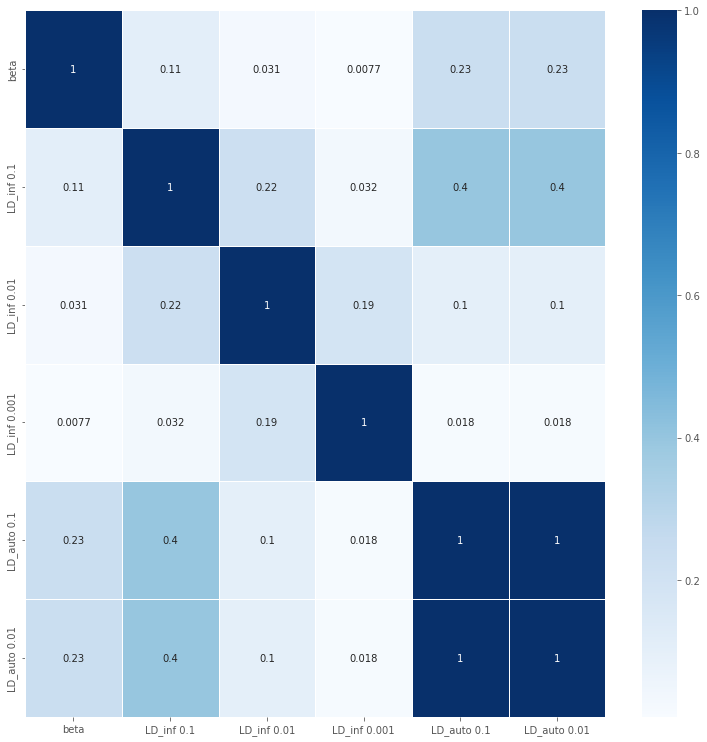

In [603]:
fig, ax = plt.subplots(figsize=(13,13))        
fig.patch.set_facecolor('xkcd:white')
x_axis_labels = ['beta','LD_inf 0.1','LD_inf 0.01','LD_inf 0.001', 'LD_auto 0.1','LD_auto 0.01'] # labels for x-axis
y_axis_labels = ['beta','LD_inf 0.1','LD_inf 0.01','LD_inf 0.001', 'LD_auto 0.1','LD_auto 0.01'] # labels for y-axis

sns.heatmap(round(dfs,4),cmap="Blues",annot=True, linewidths=.5, ax=ax,xticklabels=x_axis_labels, yticklabels=y_axis_labels)

# khera CHD

## generate csv with gene ids

In [4]:
khera_path = '/dh-projects/uk_bb_intergenics/analysis/development/upmeiejv/results/khera_phenotypes/khera_coronary_heart_disease/PGS000013.txt.snpefflike'

In [11]:
khera_chd = pd.read_csv(khera_path,sep='\t')

In [15]:
subsets_path = '/dh-projects/uk_bb_intergenics/analysis/development/aboughas/results/dataset_khera_chd_6_Mio/subsets_pgs/'

In [16]:
khera_chd.to_csv(subsets_path+'variant_subset.100k.tsv', sep ='\t', index = False )

In [19]:
khera_chd = rename_columns(khera_chd)

In [21]:
khera_chd.to_csv('/dh-projects/uk_bb_intergenics/analysis/development/aboughas/results/dataset_khera_chd_6_Mio/dataset_khera_chd_6_Mio.txt',
                 sep ='\t', index = False )

## 1-2 SNPs per gen - 68701 genes 

In [26]:
khera_with_ids_path='/dh-projects/uk_bb_intergenics/analysis/development/aboughas/results/dataset_khera_chd_6_Mio/annotated_df/snpeff_df.100k.txt'

In [27]:
khera_with_ids = pd.read_csv(khera_with_ids_path)

In [12]:
len(set(khera_with_ids.ANN_Gene_ID))

68702

In [13]:
khera_with_ids= khera_with_ids.sort_values(by="SCORE",ascending=False).reset_index(drop=True)

In [14]:
khera_with_ids = khera_with_ids[['ANN_Gene_ID','ID','CHROM','POS','REF','ALT','SCORE']]

In [19]:
grouped_khera = khera_with_ids.groupby(by=["ANN_Gene_ID"])

In [20]:
merged_khera = pd.merge(grouped_khera.head(1), grouped_khera.head(2), how='outer', indicator= True).reset_index(drop=True)

In [21]:
len(set(merged_khera.head(100_000).ANN_Gene_ID))

68701

In [22]:
merged_khera = merged_khera.rename(columns= {"CHROM":'#CHROM',
                                            'SCORE':'BETA'})

In [23]:
merged_khera = merged_khera.drop(['ANN_Gene_ID', '_merge'], axis =1)

In [24]:
merged_khera, pos= drop_duplicated_variants(merged_khera)

we have 0 variants that have switched REF and ALT


In [25]:
merged_khera= merged_khera[['#CHROM','POS','ID','REF','ALT','BETA']]

In [27]:
subset_pgs_path ='/dh-projects/uk_bb_intergenics/analysis/development/aboughas/results/dataset_khera_chd_all_genes/subsets_pgs'

In [28]:
merged_khera.head(100_000).to_csv(subset_pgs_path+'/variant_subset.100k.tsv',sep ='\t', index = False )

In [29]:
merged_khera=rename_columns(merged_khera)

In [32]:
merged_khera.head(100_000).to_csv('dataset_khera_chd_all_genes/dataset_khera_chd_all_genes.txt',sep ='\t',  index = False )

In [31]:
merged_khera

,chr_name,chr_position,ID,other_allele,effect_allele,effect_weight
0,6,161111700,rs186696265,C,T,6.238700e-02
1,6,160751531,rs9295128,G,T,4.788300e-02
2,6,12903957,rs9349379,A,G,1.763100e-02
3,6,161010118,rs10455872,A,G,1.623700e-02
4,9,22114495,rs10738609,A,G,1.546300e-02
...,...,...,...,...,...,...
136223,15,30520017,rs12440860,G,A,4.370700e-09
136224,18,15299911,rs189996318,C,T,3.449700e-09
136225,14,102537609,rs12894999,G,A,2.961400e-09
136226,12,53344993,rs143956671,A,G,2.596000e-09


## 4 SNPs per gene - 34933 genes

In [25]:
khera_with_ids_path='/dh-projects/uk_bb_intergenics/analysis/development/aboughas/results/dataset_khera_chd_6_Mio/annotated_df/snpeff_df.100k.txt'

In [28]:
khera_with_ids = pd.read_csv(khera_with_ids_path)

In [29]:
khera_with_ids= khera_with_ids.sort_values(by="SCORE",ascending=False).reset_index(drop=True)

In [30]:
khera_with_ids = khera_with_ids[['ANN_Gene_ID','ID','CHROM','POS','REF','ALT','SCORE']]

In [31]:
grouped_khera = khera_with_ids.groupby(by=["ANN_Gene_ID"])

In [68]:
grouped_khera.head(4).head(70)

,ANN_Gene_ID,ID,CHROM,POS,REF,ALT,SCORE
0,ENSG00000243831-ENSG00000224477,rs186696265,6,161111700,C,T,0.062387
1,ENSG00000112499-ENSG00000146477,rs9295128,6,160751531,G,T,0.047883
2,ENSG00000112137,rs9349379,6,12903957,A,G,0.017631
3,ENSG00000198670,rs10455872,6,161010118,A,G,0.016237
4,ENSG00000240498,rs10738609,9,22114495,A,G,0.015463
...,...,...,...,...,...,...,...
92,ENSG00000264545,rs62560774,9,22028406,A,C,0.001636
95,ENSG00000166949,rs56062135,15,67455630,T,C,0.001600
96,ENSG00000175164,rs2519093,9,136141870,C,T,0.001598
97,ENSG00000127616-ENSG00000130164,rs55997232,19,11188117,T,C,0.001592


In [76]:
merged_khera = pd.merge(grouped_khera.head(4).head(80_000), grouped_khera.head(5), how='outer', indicator= True).reset_index(drop=True)

In [78]:
merged_khera['_merge'][82_000]

'right_only'

In [79]:
len(set(merged_khera.head(100_000).ANN_Gene_ID))

34933

In [80]:
merged_khera = merged_khera.rename(columns= {"CHROM":'#CHROM',
                                            'SCORE':'BETA'})

In [81]:
merged_khera = merged_khera.drop(['ANN_Gene_ID', '_merge'], axis =1)

In [82]:
merged_khera, pos= drop_duplicated_variants(merged_khera)

we have 0 variants that have switched REF and ALT


In [83]:
merged_khera= merged_khera[['#CHROM','POS','ID','REF','ALT','BETA']]

In [84]:
subsets_pgs='/dh-projects/uk_bb_intergenics/analysis/development/aboughas/results/dataset_khera_chd_34k_genes/subsets_pgs/'

In [85]:
merged_khera.head(100_000).to_csv(subsets_pgs+'/variant_subset.100k.tsv',sep ='\t', index = False )

In [86]:
merged_khera=rename_columns(merged_khera)

In [87]:
!mkdir dataset_khera_chd_34k_genes

mkdir: cannot create directory ‘dataset_khera_chd_34k_genes’: File exists


In [88]:
merged_khera.head(100_000).to_csv('dataset_khera_chd_34k_genes/dataset_khera_chd_34k_genes.txt',sep ='\t',  index = False )

# khera atrial fibrillation

## generate csv with gene ids


In [139]:
khera_atrial_fibrillation_path = '/dh-projects/uk_bb_intergenics/analysis/development/upmeiejv/results/khera_phenotypes/khera_atrial_fibrillation/PGS000016.txt.snpefflike'

In [140]:
khera_af = pd.read_csv(khera_atrial_fibrillation_path,sep='\t')

In [149]:
subsets_path = '/dh-projects/uk_bb_intergenics/analysis/development/aboughas/results/dataset_khera_af_6MIO/subsets_pgs/'

In [150]:
khera_af.to_csv(subsets_path+'variant_subset.100k.tsv', sep ='\t', index = False )

In [151]:
khera_af = rename_columns(khera_af)

In [152]:
khera_af.to_csv('/dh-projects/uk_bb_intergenics/analysis/development/aboughas/results/dataset_khera_af_6MIO/dataset_khera_af_6MIO.txt',
                 sep ='\t', index = False )

In [153]:
khera_af

,chr_name,chr_position,ID,other_allele,effect_allele,effect_weight
0,1,30923,rs806731,T,G,4.785300e-06
1,1,52238,rs2691277,T,G,2.700000e-06
2,1,54490,rs141149254,G,A,1.565700e-06
3,1,58814,rs114420996,A,G,2.483100e-05
4,1,59040,rs62637815,C,T,1.925100e-05
...,...,...,...,...,...,...
6722552,22,51228910,rs145146472,G,A,1.428400e-06
6722553,22,51229805,rs9616985,C,T,1.455300e-06
6722554,22,51229855,rs144549712,A,G,3.669900e-07
6722555,22,51233300,rs9616839,T,C,2.576400e-06


## all_genes

In [33]:
khera_af_with_ids_path='/dh-projects/uk_bb_intergenics/analysis/development/aboughas/results/dataset_khera_af_6MIO/annotated_df/snpeff_df.100k.txt'

In [34]:
khera_af_with_ids = pd.read_csv(khera_af_with_ids_path)

In [35]:
len(set(khera_af_with_ids.ANN_Gene_ID))

69909

In [36]:
khera_af_with_ids= khera_af_with_ids.sort_values(by="SCORE",ascending=False).reset_index(drop=True)

In [37]:
khera_af_with_ids = khera_af_with_ids[['ANN_Gene_ID','ID','CHROM','POS','REF','ALT','SCORE']]

In [39]:
grouped_khera_af = khera_af_with_ids.groupby(by=["ANN_Gene_ID"])

In [40]:
merged_khera_af = pd.merge(grouped_khera_af.head(1), grouped_khera_af.head(2), how='outer', indicator= True).reset_index(drop=True)

In [41]:
len(set(merged_khera_af.head(100_000).ANN_Gene_ID))

69908

In [42]:
merged_khera_af = merged_khera_af.rename(columns= {"CHROM":'#CHROM',
                                            'SCORE':'BETA'})

In [43]:
merged_khera_af = merged_khera_af.drop(['ANN_Gene_ID', '_merge'], axis =1)

In [44]:
merged_khera_af, pos= drop_duplicated_variants(merged_khera_af)

we have 0 variants that have switched REF and ALT


In [45]:
merged_khera_af= merged_khera_af[['#CHROM','POS','ID','REF','ALT','BETA']]

In [46]:
subset_pgs_path ='/dh-projects/uk_bb_intergenics/analysis/development/aboughas/results/dataset_khera_af_all_genes/subsets_pgs'

In [47]:
merged_khera_af.head(100_000).to_csv(subset_pgs_path+'/variant_subset.100k.tsv',sep ='\t', index = False )

In [48]:
merged_khera_af=rename_columns(merged_khera_af)

In [49]:
merged_khera_af.head(100_000).to_csv('dataset_khera_af_all_genes/dataset_khera_af_all_genes.txt', index = False )

In [50]:
merged_khera_af

,chr_name,chr_position,ID,other_allele,effect_allele,effect_weight
0,4,111612804,rs9715591,T,C,1.231600e-02
1,16,73051620,rs2106261,C,T,8.500400e-03
2,4,111761487,rs3853445,C,T,7.755300e-03
3,4,111718067,rs6843082,A,G,7.340800e-03
4,16,73059159,rs4499262,C,A,4.217100e-03
...,...,...,...,...,...,...
138498,22,30823104,rs141569331,C,T,7.355700e-09
138499,6,108312182,rs72933025,A,G,4.449500e-09
138500,11,3607504,rs7120188,A,G,2.958000e-09
138501,12,65159241,rs1244797,C,T,1.471000e-09


## 4-5 SNPs per gene

In [64]:
khera_af_with_ids_path='/dh-projects/uk_bb_intergenics/analysis/development/aboughas/results/dataset_khera_af_6MIO/annotated_df/snpeff_df.100k.txt'

In [65]:
khera_af_with_ids = pd.read_csv(khera_af_with_ids_path)

In [66]:
khera_af_with_ids= khera_af_with_ids.sort_values(by="SCORE",ascending=False).reset_index(drop=True)

In [90]:
khera_af_with_ids = khera_af_with_ids[['ANN_Gene_ID','ID','CHROM','POS','REF','ALT','SCORE']]

In [91]:
grouped_khera_af = khera_af_with_ids.groupby(by=["ANN_Gene_ID"])

In [94]:
merged_khera_af = pd.merge(grouped_khera_af.head(4).head(70_000), grouped_khera_af.head(5), how='outer', indicator= True).reset_index(drop=True)

In [95]:
len(set(merged_khera_af.head(100_000).ANN_Gene_ID))

36279

In [96]:
merged_khera_af = merged_khera_af.rename(columns= {"CHROM":'#CHROM','SCORE':'BETA'})

In [97]:
merged_khera_af = merged_khera_af.drop(['ANN_Gene_ID', '_merge'], axis =1)

In [98]:
merged_khera_af, pos= drop_duplicated_variants(merged_khera_af)

we have 0 variants that have switched REF and ALT


In [100]:
merged_khera_af= merged_khera_af[['#CHROM','POS','ID','REF','ALT','BETA']]

# Khera diabetes2

## generate files with gene id

In [6]:
khera_diabetes2_path ='/dh-projects/uk_bb_intergenics/analysis/development/upmeiejv/results/khera_phenotypes/khera_diabetes2/PGS000014.txt.snpefflike'

In [7]:
khera_diabetes2 = pd.read_csv(khera_diabetes2_path,sep='\t')

In [8]:
subsets_path = '/dh-projects/uk_bb_intergenics/analysis/development/aboughas/results/dataset_khera_diabetes2_6MIO/subsets_pgs/'

In [159]:
khera_diabetes2.to_csv(subsets_path+'variant_subset.100k.tsv', sep ='\t', index = False )

In [160]:
khera_diabetes2 = rename_columns(khera_diabetes2)

In [161]:
khera_diabetes2.to_csv('/dh-projects/uk_bb_intergenics/analysis/development/aboughas/results/dataset_khera_diabetes2_6MIO/dataset_khera_diabetes2_6MIO.txt',
                 sep ='\t', index = False )

## all genes

In [7]:
khera_diabetes2_with_ids_path='/dh-projects/uk_bb_intergenics/analysis/development/aboughas/results/dataset_khera_diabetes2_6MIO/annotated_df/snpeff_df.100k.txt'

In [8]:
khera_diabetes2_with_ids = pd.read_csv(khera_diabetes2_with_ids_path)

In [9]:
len(set(khera_diabetes2_with_ids.ANN_Gene_ID))

69618

In [10]:
khera_diabetes2_with_ids= khera_diabetes2_with_ids.sort_values(by="SCORE",ascending=False).reset_index(drop=True)

In [55]:
khera_diabetes2_with_ids = khera_diabetes2_with_ids[['ANN_Gene_ID','ID','CHROM','POS','REF','ALT','SCORE']]

In [56]:
khera_diabetes2_with_ids

,ANN_Gene_ID,ID,CHROM,POS,REF,ALT,SCORE
0,ENSG00000148737,rs7903146,10,114758349,C,T,4.848500e-03
1,ENSG00000148737,rs35198068,10,114754784,T,C,4.581800e-03
2,ENSG00000148737,rs34872471,10,114754071,T,C,4.271500e-03
3,ENSG00000148737,rs36090025,10,114774433,A,C,3.708600e-03
4,ENSG00000148737,rs56087297,10,114799172,A,G,2.788000e-03
...,...,...,...,...,...,...,...
6909486,ENSG00000249831-ENSG00000248660,rs28798695,4,58764226,A,G,7.348900e-12
6909487,ENSG00000182831,rs144088761,16,9181149,C,A,4.941000e-12
6909488,ENSG00000120907,rs117384411,8,26650098,G,A,3.263400e-12
6909489,ENSG00000259140-ENSG00000239269,rs114428340,14,95177610,A,C,1.651900e-12


In [57]:
grouped_khera_diabetes2 = khera_diabetes2_with_ids.groupby(by=["ANN_Gene_ID"])

In [58]:
merged_diabetes2 = pd.merge(grouped_khera_diabetes2.head(1), grouped_khera_diabetes2.head(2), how='outer', indicator= True).reset_index(drop=True)

In [59]:
len(set(merged_diabetes2.head(100_000).ANN_Gene_ID))

69617

In [60]:
merged_diabetes2 = merged_diabetes2.rename(columns= {"CHROM":'#CHROM',
                                            'SCORE':'BETA'})

In [61]:
merged_diabetes2 = merged_diabetes2.drop(['ANN_Gene_ID', '_merge'], axis =1)

In [62]:
merged_diabetes2, pos= drop_duplicated_variants(merged_diabetes2)

we have 0 variants that have switched REF and ALT


In [63]:
merged_diabetes2= merged_diabetes2[['#CHROM','POS','ID','REF','ALT','BETA']]

In [64]:
subset_pgs_path ='/dh-projects/uk_bb_intergenics/analysis/development/aboughas/results/dataset_khera_diabetes2_all_genes/subsets_pgs'

In [65]:
merged_diabetes2.head(100_000).to_csv(subset_pgs_path+'/variant_subset.100k.tsv',sep ='\t', index = False )

In [66]:
merged_diabetes2=rename_columns(merged_diabetes2)

In [67]:
!mkdir dataset_khera_diabetes2_all_genes

mkdir: cannot create directory ‘dataset_khera_diabetes2_all_genes’: File exists


In [68]:
merged_diabetes2.head(100_000).to_csv('dataset_khera_diabetes2_all_genes/dataset_khera_diabetes2_all_genes.txt', sep ='\t',index = False )

# khera inflammatory bowel

## generate files with gene id

In [96]:
khera_inb_path ='/dh-projects/uk_bb_intergenics/analysis/development/upmeiejv/results/khera_phenotypes/khera_inflammatory_bowel/PGS000017.txt.snpefflike'

In [97]:
khera_inb = pd.read_csv(khera_inb_path,sep='\t')

In [102]:
subsets_path='/dh-projects/uk_bb_intergenics/analysis/development/aboughas/results/dataset_khera_inb_6MIO/subsets_pgs/'

In [103]:
khera_inb.to_csv(subsets_path+'variant_subset.100k.tsv', sep ='\t', index = False )

In [104]:
khera_inb = rename_columns(khera_inb)

In [107]:
khera_inb.to_csv('/dh-projects/uk_bb_intergenics/analysis/development/aboughas/results/dataset_khera_inb_6MIO/dataset_khera_inb_6MIO.txt',
                 sep ='\t', index = False )

In [116]:
khera_inb

,chr_name,chr_position,ID,other_allele,effect_allele,effect_weight
0,1,54490,rs141149254,A,G,0.000033
1,1,55326,rs3107975,T,C,0.000106
2,1,58814,rs114420996,G,A,0.000068
3,1,64649,rs181431124,A,C,0.000102
4,1,88316,rs113759966,G,A,0.000057
...,...,...,...,...,...,...
6899209,22,51229805,rs9616985,C,T,0.000021
6899210,22,51229855,rs144549712,G,A,0.000027
6899211,22,51233300,rs9616839,T,C,0.000008
6899212,22,51234799,rs191117135,G,A,0.000193


## all genes

In [2]:
khera_inb_with_ids_path = '/dh-projects/uk_bb_intergenics/analysis/development/aboughas/results/dataset_khera_inb_6MIO/annotated_df/snpeff_df.100k.txt'

In [3]:
khera_inb_with_ids = pd.read_csv(khera_inb_with_ids_path)

In [4]:
len(set(khera_inb_with_ids.ANN_Gene_ID))

69802

In [5]:
khera_inb_with_ids= khera_inb_with_ids.sort_values(by="SCORE",ascending=False).reset_index(drop=True)

In [6]:
khera_inb_with_ids = khera_inb_with_ids[['ANN_Gene_ID','ID','CHROM','POS','REF','ALT','SCORE']]

In [7]:
khera_inb_with_ids = khera_inb_with_ids.groupby(by=["ANN_Gene_ID"])

In [8]:
merged_inb=pd.merge(khera_inb_with_ids.head(1), khera_inb_with_ids.head(2), how='outer', indicator= True).reset_index(drop=True)

In [9]:
len(set(merged_inb.head(100_000).ANN_Gene_ID))

69801

In [10]:
merged_inb = merged_inb.rename(columns= {"CHROM":'#CHROM',
                                            'SCORE':'BETA'})

In [11]:
merged_inb

,ANN_Gene_ID,ID,#CHROM,POS,REF,ALT,BETA,_merge
0,ENSG00000196126-ENSG00000196735,rs73410656,6,32577308,G,A,3.430300e-03,both
1,ENSG00000229391,rs78653427,6,32523703,C,T,2.835400e-03,both
2,ENSG00000225914-ENSG00000204296,rs145568234,6,32247045,T,G,2.753000e-03,both
3,ENSG00000251916,rs112469879,6,32515216,G,A,2.657000e-03,both
4,ENSG00000196301-ENSG00000198502,rs183183311,6,32453410,C,A,2.635300e-03,both
...,...,...,...,...,...,...,...,...
138375,ENSG00000238107,rs6696635,1,147767162,C,T,1.081600e-07,right_only
138376,ENSG00000256750-ENSG00000255618,rs10774993,12,119205352,G,T,1.074100e-07,right_only
138377,ENSG00000259198,rs11635059,15,40610633,C,T,7.887100e-08,right_only
138378,ENSG00000177692-ENSG00000159131,rs7278879,21,34871133,C,T,5.172200e-08,right_only


In [13]:
subsets_pgs_path ='/dh-projects/uk_bb_intergenics/analysis/development/aboughas/results/dataset_khera_inb_all_genes/subsets_pgs/'

In [17]:
merged_inb, pos= drop_duplicated_variants(merged_inb)

we have 0 variants that have switched REF and ALT


In [18]:
merged_inb = merged_inb.drop(['ANN_Gene_ID', '_merge'], axis =1)

In [19]:
merged_inb = merged_inb[['#CHROM','POS','ID','REF','ALT','BETA']]

In [20]:
merged_inb.head(100_000).to_csv(subsets_pgs_path+'/variant_subset.100k.tsv',sep ='\t', index = False )

In [21]:
merged_inb = rename_columns(merged_inb)

In [22]:
!mkdir dataset_khera_inb_all_genes

mkdir: cannot create directory ‘dataset_khera_inb_all_genes’: File exists


In [23]:
merged_inb.head(100_000).to_csv('dataset_khera_inb_all_genes/dataset_khera_inb_all_genes.txt', index = False )

# compare_approaches

In [446]:
best_beta = pd.read_csv('dataset_top_beta/dataset_top_beta.txt')

In [290]:
best_pval = pd.read_csv('dataset_top_100k_pval/dataset_top_100k_pval.txt')

In [282]:
most_common = pd.read_csv('dataset_most_common/dataset_most_common.txt')

In [288]:
random_qtls = pd.read_csv('dataset_random_select/dataset_random_select.txt')

In [260]:
all_traits = pd.read_csv('dataset_different_genes/dataset_all_genes_top_pval.txt')

In [268]:
all_genes = pd.read_csv('dataset_snps_mapped_to_all_genes/dataset_snps_mapped_to_all_genes.txt',sep = '\t')

In [289]:
random_snps = pd.read_csv('dataset_random_select/dataset_random_select_all_snps.txt')

In [488]:
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

In [296]:
dfs = pd.DataFrame([1], index=['best_pval'], columns=['best_pval'])

## add the datasets

In [319]:
new_df = random_snps
new_df_name = 'random_snps'


In [320]:
l = []
for d in dfs.columns.to_list():
    l.append(jaccard_similarity(new_df.head(100_000).ID, locals()[d].head(100_000).ID))

In [321]:
df2 = pd.DataFrame([l], columns=dfs.columns.to_list(), index=[new_df_name])
dfs = dfs.append(df2)
dfs[new_df_name] = l + [1]

/tmp/ipykernel_3837350/3422173701.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfs = dfs.append(df2)


In [322]:
dfs

,best_pval,best_beta,most_common,all_traits,all_genes,random_qtls,random_snps
best_pval,1.000000,0.000090,0.358899,0.041851,0.017713,0.044343,0.000545
best_beta,0.000090,1.000000,0.000055,0.003110,0.004571,0.002285,0.000610
most_common,0.358899,0.000055,1.000000,0.027586,0.014574,0.063700,0.000510
all_traits,0.041851,0.003110,0.027586,1.000000,0.018698,0.011926,0.000550
all_genes,0.017713,0.004571,0.014574,0.018698,1.000000,0.007196,0.000585
random_qtls,0.044343,0.002285,0.063700,0.011926,0.007196,1.000000,0.000525
random_snps,0.000545,0.000610,0.000510,0.000550,0.000585,0.000525,1.000000


<AxesSubplot:>

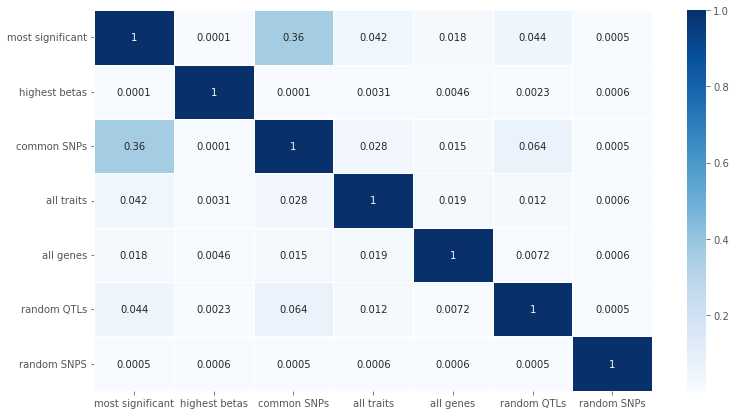

In [374]:
fig, ax = plt.subplots(figsize=(12.5,7))         # Sample figsize in inches
fig.patch.set_facecolor('xkcd:white')
x_axis_labels = ['most significant','highest betas','common SNPs','all traits','all genes','random QTLs','random SNPs'] # labels for x-axis
y_axis_labels = ['most significant','highest betas','common SNPs','all traits','all genes','random QTLs','random SNPS'] # labels for y-axis

sns.heatmap(round(dfs,4),cmap="Blues",annot=True, linewidths=.5, ax=ax,xticklabels=x_axis_labels, yticklabels=y_axis_labels)

In [363]:
fig.savefig("output_fc.png",transparent= True,facecolor= fig.get_facecolor())




# PGS

In [526]:
diabetes_pgs = pd.read_csv('/dh-projects/uk_bb_intergenics/analysis/results/auto_prs/PGS000014/PGS000014.txt',skiprows=15,sep ='\t')

In [527]:
diabetes_pgs

,chr_name,chr_position,effect_allele,other_allele,effect_weight
0,1,55326,T,C,4.774600e-06
1,1,64649,A,C,2.470800e-05
2,1,662622,G,A,2.650700e-05
3,1,693731,A,G,1.774900e-05
4,1,701835,T,C,8.087600e-06
...,...,...,...,...,...
6917431,22,51228910,G,A,9.573100e-06
6917432,22,51229805,C,T,1.322700e-06
6917433,22,51229855,G,A,9.534400e-07
6917434,22,51233300,C,T,5.013300e-06


# Map to hg19

In [397]:
hg38= grouped.drop(['ID'], axis=1).head(150_000)
hg38= hg38[["#CHROM", "POS","BETA", "REF","ALT"]]


In [13]:
hg19.drop_duplicates(['#CHROM','POS'])

,#CHROM,POS,BETA,REF,ALT
0,17,19578873,8.257220e-249,A,T
1,17,19570320,8.257220e-249,A,G
2,17,19565945,8.257220e-249,G,A
3,17,19563018,8.257220e-249,C,G
4,17,19559468,8.257220e-249,A,G
...,...,...,...,...,...
149256,3,124734326,7.051210e-44,C,T
149257,19,37740358,7.052240e-44,A,G
149258,18,61587067,7.054270e-44,C,T
149259,19,20723794,7.059090e-44,A,AT


In [10]:
hg19 = pd.read_csv('hg19/hg19data.txt',sep = '\t')

In [410]:
hg19.loc[hg19.POS == 57089991]

,#CHROM,POS,BETA,REF,ALT
27648,12,57089991,3.157420e-88,TATACATAC,T
27649,12,57089991,3.157420e-88,TATACATAC,T


In [408]:
hg19.groupby(['#CHROM','POS', 'ALT']).size().reset_index(name='Freq').sort_values(by= 'Freq', ascending = False)

,#CHROM,POS,ALT,Freq
92717,12,57089991,T,2
121122,17,42424484,CA,2
87343,11,86020052,AAT,2
144108,21,45434264,AT,2
127987,17,79836977,CAGG,2
...,...,...,...,...
49751,6,31312350,A,1
49752,6,31312363,T,1
49753,6,31312399,T,1
49754,6,31312428,A,1


In [398]:
hg38.to_csv('hg38_data.txt',sep ='\t', index = False )


In [223]:
grouped["variant"]=grouped["variant"].apply(lambda x:variant_idx[int(x)])
grouped["ID"]=grouped["ID"].apply(lambda x:rsid_idx[int(x)])
grouped['#CHROM']=grouped['variant'].apply(lambda x:int(re.search(r'\d+',x.split('_')[0]).group()))
grouped['POS']=grouped['variant'].apply(lambda x: x.split('_')[1])
grouped['REF']=grouped['variant'].apply(lambda x: x.split('_')[2])
grouped['ALT']=grouped['variant'].apply(lambda x: x.split('_')[3])

In [231]:
grouped= grouped.rename(columns= {'pvalue' : 'BETA'})

In [233]:
grouped = grouped[['#CHROM'  ,'POS' ,'ID'  , 'REF' ,    'ALT',     'BETA']]

In [ ]:
grouped.head(100_000).groupby(['POS', 'ALT']).size().reset_index(name='Freq').sort_values(by= 'Freq', ascending = False)

In [244]:
grouped.head(100_000).to_csv('/dh-projects/uk_bb_intergenics/analysis/development/aboughas/results/dataset_100k_top_pval/annotated/snpeff_temp.100k.txt', 
                             sep ='\t', index = False )


In [242]:
grouped = grouped.rename(columns= {'chr_name' :"#CHROM",
                                 "chr_position":  "POS",
                                  "effect_allele": "ALT", 
                                 "other_allele": "REF",
                                 "effect_weight": "BETA"})

In [237]:
grouped = grouped.rename(columns= {"#CHROM" : 'chr_name',
                                  "POS": "chr_position",
                                  "ALT" :"effect_allele", 
                                  "REF": "other_allele",
                                  "BETA":"effect_weight"})

In [286]:
test1 = grouped.head(100_000).loc[grouped.head(100_000).POS.isin(test.POS)]

In [294]:
test1.groupby(['#CHROM','POS', 'ID', 'REF']).size().reset_index(name='Freq1').sort_values(by='ID')

,#CHROM,POS,ID,REF,Freq1
22,17,46220996,rs10095129,C,2
5,1,62714976,rs10141400,C,2
15,14,88521566,rs10740302,C,2
18,17,46156899,rs10777524,C,2
21,17,46200038,rs11631500,T,3
3,1,169348896,rs12098340,C,2
14,14,103645762,rs12701220,C,2
19,17,46185656,rs132745,C,2
1,1,151927115,rs1896042,C,2
6,4,82848313,rs35181240,C,2


In [278]:
test = grouped.head(100_000).groupby(['#CHROM','POS', 'ID']).size().reset_index(name='Freq').sort_values(by= 'Freq', ascending = False)

In [283]:
test = test.loc[test.Freq >1]

In [296]:
test3 = test = grouped.head(100_000).groupby(['#CHROM','POS', 'REF']).size().reset_index(name='Freq').sort_values(by= 'Freq', ascending = False)

In [301]:
test3

,#CHROM,POS,REF,Freq
82055,17,46200038,T,3
57947,11,86309010,A,2
79145,17,44347116,C,2
80152,17,45786127,C,2
385,1,151927115,C,2
...,...,...,...,...
33323,6,31481550,A,1
33322,6,31481199,C,1
33321,6,31480787,G,1
33320,6,31477568,T,1


In [390]:
grouped.loc[grouped.POS == '161628488']   
# molecular_trait_id	variant	pvalue	molecular_trait_object_id	rsid
# 38733764	ENST00000367967	chr1_161628488_C_G	2.827930e-71	ENSG00000203747	rs34612244

,#CHROM,POS,ID,REF,ALT,BETA
51970,1,161628488,rs141036076,C,G,2.827930e-71


In [241]:
grouped.head(100_000).to_csv('dataset_100k_top_pval/dataset_100k_top_pval.txt', sep ='\t', index = False )


In [9]:
# read sumstats
sumstats = pd.read_csv('hg19/sumstats38.txt',sep = '\t')

In [11]:
sumstats_19 =  pd.read_csv('hg19/sumstats_hg19_rs',sep = '\t')

/tmp/ipykernel_72188/3770765730.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  sumstats_19 =  pd.read_csv('hg19/sumstats_hg19_rs',sep = '\t')


In [15]:
sumstats_19 =sumstats_19.rename(columns= {"BETA" : 'markername'})

In [17]:
m = pd.merge(sumstats_19,sumstats, on='markername', indicator= True)

In [20]:
m = m.loc[m._merge=='both']

In [23]:
m

,#CHROM,POS,markername,REF,ALT,chr,pb_hg38,noneffect_allele,effect_allele,beta,se_dgc,p_dgc,_merge
0,17,19578873,rs7216,A,T,17,19675560,A,T,1.216870,0.022591,8.257220e-249,both
1,17,19570320,rs8069576,A,G,17,19667007,A,G,1.216870,0.022591,8.257220e-249,both
2,17,19565945,rs2108971,G,A,17,19662632,G,A,1.216870,0.022591,8.257220e-249,both
3,17,19563018,rs2386145,C,G,17,19659705,C,G,1.216870,0.022591,8.257220e-249,both
4,17,19559468,rs962800,A,G,17,19656155,A,G,1.216870,0.022591,8.257220e-249,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14568117,10,27125951,rs192635431,A,G,10,26837022,A,G,1.372520,0.468922,4.999980e-03,both
14568118,3,1947516,rs73821368,C,G,3,1905832,C,G,-0.417140,0.147895,4.999990e-03,both
14568119,7,89577313,rs187383325,G,T,7,89947999,G,T,-0.718601,0.253782,4.999990e-03,both
14568120,7,67356064,rs149024095,G,A,7,67891077,G,A,2.137290,0.739216,4.999990e-03,both


In [24]:
m = m.drop(['_merge','noneffect_allele','effect_allele','pb_hg38','chr'], axis=1).rename(columns= {"POS":'pb_hg19',
                                                                                              '#CHROM':'chr',
                                                                                              'REF':'noneffect_allele',
                                                                                              'ALT':'effect_allele'})

In [27]:
m = m[['markername','chr','pb_hg19','noneffect_allele','effect_allele','beta','se_dgc','p_dgc']]

In [29]:
m.to_csv('LDpred/sumstats_hg19.txt',sep ='\t', index = False )

In [5]:
sumstats = sumstats.rename(columns= {'chr':'#CHROM',
                                    'pb_hg38':'POS',
                                    "effect_allele":"ALT",
                                    "noneffect_allele":"REF",
                                    'markername':'BETA'})

In [8]:
sumstats

,#CHROM,POS,BETA,REF,ALT
0,17,19675560,rs7216,A,T
1,17,19667007,rs8069576,A,G
2,17,19662632,rs2108971,G,A
3,17,19659705,rs2386145,C,G
4,17,19656155,rs962800,A,G
...,...,...,...,...,...
14589653,10,26837022,rs192635431,A,G
14589654,3,1905832,rs73821368,C,G
14589655,7,89947999,rs187383325,G,T
14589656,7,67891077,rs149024095,G,A


In [6]:
sumstats = sumstats[["#CHROM", "POS","BETA", "REF","ALT"]]

In [7]:
sumstats.to_csv('hg19/sumstats_hg38.txt',sep ='\t', index = False )

In [ ]:
with open(vcf, mode='r') as vcf:
    print(vcf.read())

In [29]:
vcf = '/dh-projects/uk_bb_intergenics/raw_data/analysis_data/agnostic/1000genomes/phase4/ALL.chr22.shapeit2_integrated_snvindels_v2a_27022019.GRCh38.phased.vcf'

# plot qtls

In [497]:
grouped["study"] = grouped["study"].apply(lambda x:  study_idx[x])
grouped["variant"] = grouped["variant"].apply(lambda x:  variant_idx[x])
grouped["molecular_trait_object_id"] = grouped["molecular_trait_object_id"].apply(lambda x:  molecular_trait_object_id_idx[x])
grouped["molecular_trait_id"] = grouped["molecular_trait_id"].apply(lambda x:  molecular_trait_id_idx[x])
grouped['#CHROM']  = grouped['variant'].apply(lambda x: int(re.search(r'\d+', x.split('_')[0]).group()))


In [499]:
grouped['POS'] =  grouped['variant'].apply(lambda x: int(x.split('_')[1]))

In [500]:
grouped

,molecular_trait_object_id,molecular_trait_id,variant,study,pvalue,#CHROM,POS
0,ENSG00000084072,ENST00000495526,chr1_39746065_T_C,GTEx_tx_muscle,2.335900e-230,1,39746065
1,ENSG00000104763,ENST00000637095,chr8_18072845_A_C,GTEx_tx_muscle,6.574620e-190,8,18072845
2,ENSG00000176731,ENST00000612977,chr8_85218394_A_G,GTEx_tx_muscle,3.197960e-188,8,85218394
3,ENSG00000163319,ENST00000507349,chr4_83454644_C_A,GTEx_tx_muscle,6.385270e-186,4,83454644
4,ENSG00000221923,ENST00000422689,chr19_52379870_T_C,ROSMAP_tx_brain_naive,3.737270e-184,19,52379870
...,...,...,...,...,...,...,...
5499464,ENSG00000259636,ENST00000560696,chr15_87417768_G_A,Braineac2_tx_substantia_nigra,4.999980e-02,15,87417768
5499465,ENSG00000266714,ENST00000578300,chr17_76013086_C_T,Schmiedel_2018_tx_CD8_T-cell_naive,4.999990e-02,17,76013086
5499466,ENSG00000095321,ENST00000393384,chr9_130076973_C_T,Braineac2_tx_putamen,4.999990e-02,9,130076973
5499467,ENSG00000115266,ENST00000587869,chr19_672915_C_CA,Peng_2018_tx_placenta_naive,4.999990e-02,19,672915


In [399]:
grouped.groupby(['molecular_trait_object_id'])['pvalue'].count()

molecular_trait_object_id
ENSG00000000419    208
ENSG00000000457    204
ENSG00000000460    404
ENSG00000000938    116
ENSG00000000971    157
                  ... 
ENSG00000286266     10
ENSG00000286269     10
ENSG00000286270      6
ENSG00000286271     24
ENSG00000286272      3
Name: pvalue, Length: 32910, dtype: int64

In [400]:
grouped.groupby(['molecular_trait_object_id','molecular_trait_id'])['pvalue'].count()

molecular_trait_object_id  molecular_trait_id
ENSG00000000419            ENST00000371582       35
                           ENST00000371584       35
                           ENST00000371588       35
                           ENST00000413082       34
                           ENST00000466152       33
                                                 ..
ENSG00000286266            ENST00000652749        4
ENSG00000286269            ENST00000650758       10
ENSG00000286270            ENST00000652087        6
ENSG00000286271            ENST00000651306       24
ENSG00000286272            ENST00000651076        3
Name: pvalue, Length: 173209, dtype: int64

Text(0.5, 0, 'study')

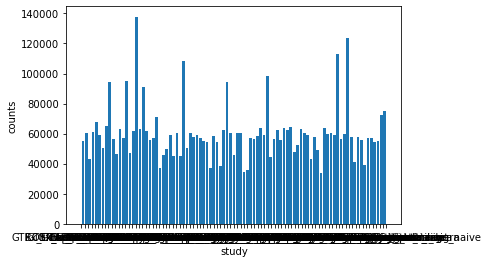

In [417]:
plt.hist(grouped['study'], bins= 91, rwidth=0.8)  # density=False would make counts
plt.ylabel('counts')
plt.xlabel('study')

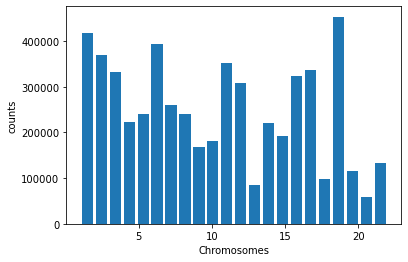

In [391]:
plt.hist(grouped['#CHROM'], bins= 22, rwidth=0.8)  # density=False would make counts
plt.ylabel('counts')
plt.xlabel('Chromosomes')

In [434]:
grouped['log_p']  = - np.log10(grouped['pvalue'] )

In [465]:
int(grouped['POS'][0])

39746065

In [436]:
grouped.loc[grouped['#CHROM']==1].sort_values(by="log_p")

,molecular_trait_object_id,molecular_trait_id,variant,study,pvalue,#CHROM,POS,log_p
5499432,ENSG00000117640,ENST00000374307,chr1_24865521_G_A,PhLiPS_tx_iPSC,4.999830e-02,1,24865521,1.301045
5499381,ENSG00000171163,ENST00000495731,chr1_248286440_T_C,PhLiPS_tx_HLC,4.999610e-02,1,248286440,1.301064
5499378,ENSG00000198771,ENST00000367854,chr1_168254505_G_A,FUSION_tx_adipose_naive,4.999600e-02,1,168254505,1.301065
5499376,ENSG00000198756,ENST00000361927,chr1_184824503_A_G,PhLiPS_tx_HLC,4.999590e-02,1,184824503,1.301066
5499371,ENSG00000143614,ENST00000637918,chr1_152990523_T_C,BrainSeq_tx_brain,4.999570e-02,1,152990523,1.301067
...,...,...,...,...,...,...,...,...
177,ENSG00000117481,ENST00000498008,chr1_46389072_G_A,GEUVADIS_tx_LCL,1.011260e-99,1,46389072,98.995137
135,ENSG00000117395,ENST00000483082,chr1_43172514_A_G,ROSMAP_tx_brain_naive,6.517440e-108,1,43172514,107.185923
96,ENSG00000135862,ENST00000478064,chr1_183108480_C_T,GTEx_tx_adipose_subcutaneous,1.168610e-113,1,183108480,112.932330
41,ENSG00000135862,ENST00000478064,chr1_183112732_G_A,GTEx_tx_nerve_tibial,4.694320e-125,1,183112732,124.328427


In [501]:
grouped['POS'][0]

39746065

[]

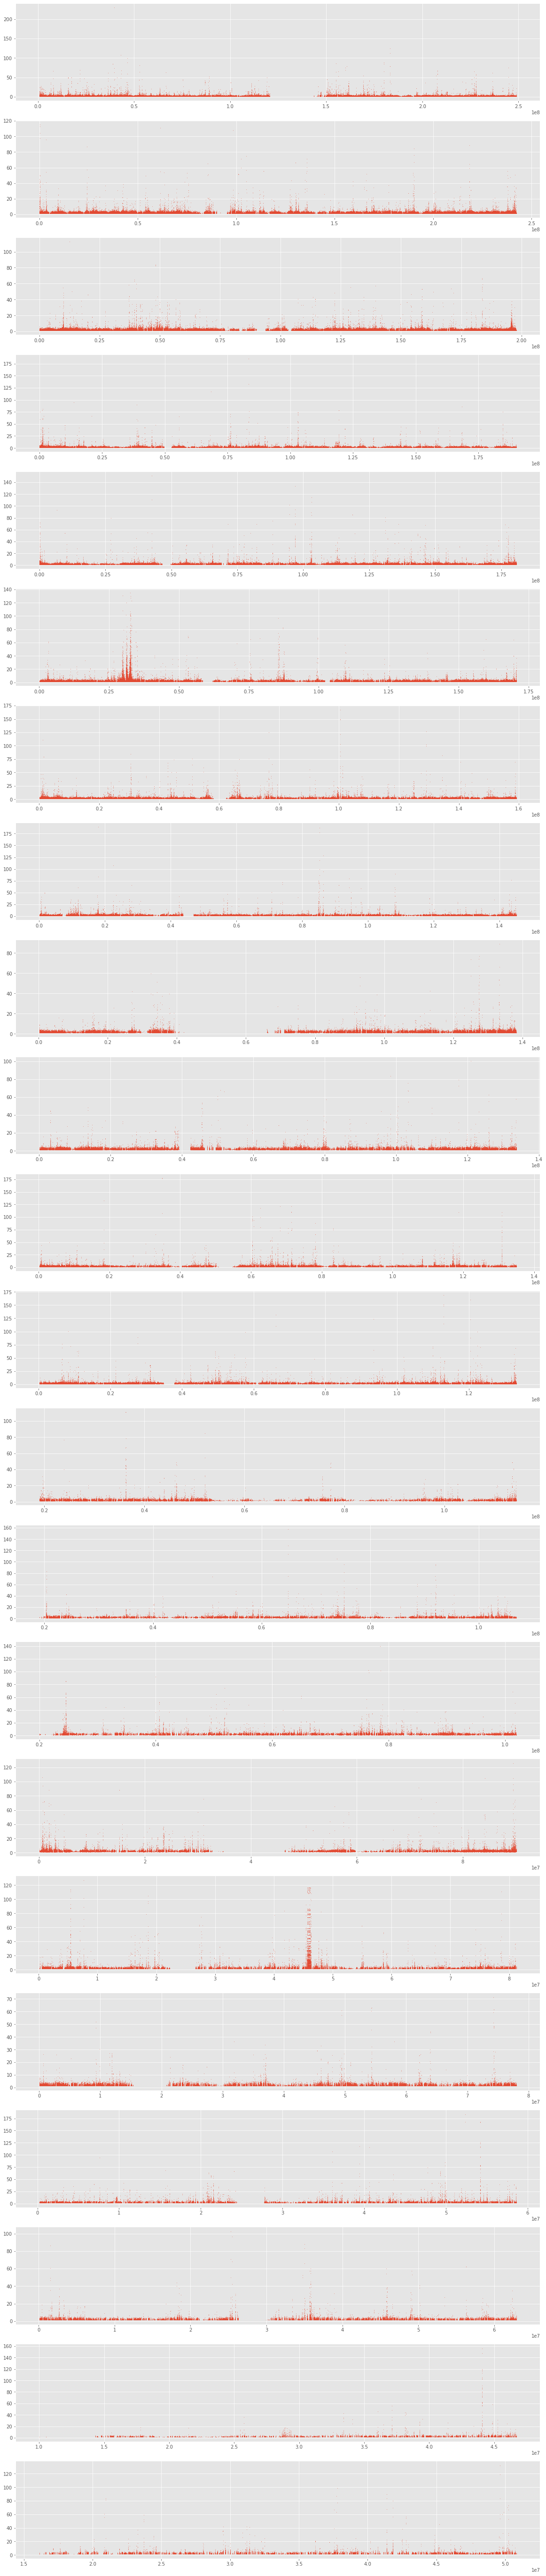

In [512]:
fig, axs = plt.subplots(22)
for i in range (22):
    axs[i].scatter(grouped.loc[grouped['#CHROM'] == i+1]['POS'],- np.log10(grouped.loc[grouped['#CHROM'] == i+1]['pvalue']), s = 0.1)
    
plt.rcParams["figure.figsize"] = [20, 100]
plt.plot()

In [414]:
grouped_chr_1 = grouped.loc[grouped['#CHROM'] == 6]

- np.log10(grouped_chr_1['pvalue'])

24         134.922941
30         131.104014
31         130.145939
35         127.430898
44         123.313518
              ...    
5499404      1.301054
5499417      1.301050
5499436      1.301044
5499438      1.301044
5499440      1.301042
Name: pvalue, Length: 393374, dtype: float64

# sparse matrix

In [ ]:
coo_list = [molecular_trait_object_id, molecular_trait_id, variant, study]

In [182]:
t = torch.sparse_coo_tensor(coo_list, pvalue,
                            (max(coo_list[0])+1, max(coo_list[1])+1,max(coo_list[2])+1,max(coo_list[3])+1),
                           dtype = torch.float64)

In [183]:
data_tensor = SparseTensor.from_torch_sparse_coo_tensor(t)

In [184]:
data_tensor

SparseTensor(row=tensor([    0,     0,     0,  ..., 32907, 32908, 32909]),
             col=tensor([ 32919,  32919,  32919,  ..., 173151, 173138, 173208]),
             val=tensor([0.0450, 0.0441, 0.0084,  ..., 0.0438, 0.0424, 0.0363],
                          dtype=torch.float64),
             size=(32910, 173209), nnz=20391628, density=0.36%)

In [196]:
i = [[0, 0, 0, 3, 3],
     [2, 2, 2, 1, 1],
     [1, 2, 0, 1, 1]] 
v =  [3, 4, 5, 8, 6]
s = torch.sparse_coo_tensor(i, v, (max(i[0]) +1, max(i[1])+1, max(i[2])+1), dtype = torch.float64)
print(s)

tensor(indices=tensor([[0, 0, 0, 3, 3],
                       [2, 2, 2, 1, 1],
                       [1, 2, 0, 1, 1]]),
       values=tensor([3., 4., 5., 8., 6.]),
       size=(4, 3, 3), nnz=5, dtype=torch.float64, layout=torch.sparse_coo)


In [197]:
from torch_sparse import SparseTensor
from torch_sparse.reduce import reduction

te = SparseTensor.from_torch_sparse_coo_tensor(s)
maxima = reduction(te, dim=-1, reduce='max')

In [201]:
s.dim()

3

In [199]:
SparseTensor.to_torch_sparse_coo_tensor(te)

tensor(indices=tensor([[0, 0, 0, 3],
                       [2, 2, 2, 1]]),
       values=tensor([ 5.,  3.,  4., 14.]),
       size=(4, 3), nnz=4, dtype=torch.float64, layout=torch.sparse_coo)

In [178]:
mmm = SparseTensor.from_torch_sparse_coo_tensor(s)

In [180]:
mmm.max(dim = -1)

tensor([ 5.,  0.,  0., 14.], dtype=torch.float64)

In [175]:
import numpy as np
from scipy.sparse import csr_matrix
A = csr_matrix([[1, 2, 0], [0, 0, 3], [4, 0, 5]])
v = np.array([1, 0, -1])
A.dot(v)

array([ 1, -3, -1])

In [19]:
print(s.to_dense())
s.dense_dim()

list

In [44]:
class sparse_3d: 
    
  def __init__(self, array, idx1, idx2, not_converted_idx, val):
    self.array = array
    self.idx1 = idx1
    self.idx2 = idx2
    self.not_converted_idx = not_converted_idx
    self.val = val
    
  def coo_3d_matrix(self):
    not_converted = self.array[:,self.not_converted_idx]
    new_idx = ((self.array [:,self.idx1]) * max(self.array [:,self.idx2])) + (self.array [:,self.idx2])
    rows, cols = zip(*np.vstack((not_converted, new_idx)).T)
    coo = coo_matrix((self.val.flatten(), (rows, cols)))
    return(coo)


In [9]:
data = pd.read_csv(studies[0],sep='\t',usecols =['molecular_trait_object_id','variant','pvalue'] )

In [13]:
f = filter_subset(data, gwas_data, 0.05)

In [15]:
f.drop(['id','_merge'], inplace=True, axis=1)

In [17]:
f['study'] = studies[0].split('.')[:-2][0]


In [29]:
p_array, p_pval = preprocess_subset(f,[],[],[])

study   molecular_trait_object_id   variant


In [45]:
p_sparse = sparse_3d(p_array,1,2,0,p_pval)

In [46]:
sparse = p_sparse.coo_3d_matrix()

In [54]:
type(sparse)

scipy.sparse._coo.coo_matrix

In [56]:
sparse

<1x449034911 sparse matrix of type '<class 'numpy.float64'>'
	with 118441 stored elements in COOrdinate format>

In [55]:
sparse.toarray()

array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.0214086]])

In [ ]:

t = torch.topk(s._values(), 2, largest=True, sorted=True, out=None)
t.indices

In [294]:
# importing pandas
import pandas as pd
	
# declare a dictionary
record = {

'Name' : ['Ankit', 'Swapnil', 'Aishwarya','Priyanka', 'Shivangi', 'Shaurya' ],
	
'Age' : [22, 20, 21, 19, 18, 22],
	
'Stream' : ['Math', 'Commerce', 'Science','Math', 'Math', 'Science'],
	
'Percentage' : [90, 90, 96, 75, 70, 80] }
	
# create a dataframe
dataframe = pd.DataFrame(record,
columns = ['Name', 'Age',
'Stream', 'Percentage'])
# show the Dataframe
print("Given Dataframe :\n", dataframe)


Given Dataframe :
         Name  Age    Stream  Percentage
0      Ankit   22      Math          90
1    Swapnil   20  Commerce          90
2  Aishwarya   21   Science          96
3   Priyanka   19      Math          75
4   Shivangi   18      Math          70
5    Shaurya   22   Science          80


In [306]:
options = ['Science', 'Commerce']

# selecting rows based on condition
rslt_df = dataframe[dataframe['Stream'].isin(options)]

print('\nResult dataframe :\n', rslt_df)



Result dataframe :
         Name  Age    Stream  Percentage
1    Swapnil   20  Commerce          90
2  Aishwarya   21   Science          96
5    Shaurya   22   Science          80


In [304]:
ddd =  pd.DataFrame(options,columns = ['Stream'])

In [305]:
ddd

,Stream
0,Science
1,Commerce


In [307]:
pd.merge(dataframe, ddd, on = "Stream")

,Name,Age,Stream,Percentage
0,Swapnil,20,Commerce,90
1,Aishwarya,21,Science,96
2,Shaurya,22,Science,80


# seperate Chr

In [4]:
sumstats_path_hg19 = "/dh-projects/uk_bb_intergenics/analysis/qtls/LDpred/sumstats_hg19.txt"
sumstats_hg19 = pd.read_csv(sumstats_path_hg19, sep= '\t')

/tmp/ipykernel_2444498/913499006.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  sumstats_hg19 = pd.read_csv(sumstats_path_hg19, sep= '\t')


In [5]:
sumstats_hg19

,markername,chr,pb_hg19,noneffect_allele,effect_allele,beta,se_dgc,p_dgc
0,rs7216,17,19578873,A,T,1.216870,0.022591,8.257220e-249
1,rs8069576,17,19570320,A,G,1.216870,0.022591,8.257220e-249
2,rs2108971,17,19565945,G,A,1.216870,0.022591,8.257220e-249
3,rs2386145,17,19563018,C,G,1.216870,0.022591,8.257220e-249
4,rs962800,17,19559468,A,G,1.216870,0.022591,8.257220e-249
...,...,...,...,...,...,...,...,...
14568117,rs192635431,10,27125951,A,G,1.372520,0.468922,4.999980e-03
14568118,rs73821368,3,1947516,C,G,-0.417140,0.147895,4.999990e-03
14568119,rs187383325,7,89577313,G,T,-0.718601,0.253782,4.999990e-03
14568120,rs149024095,7,67356064,G,A,2.137290,0.739216,4.999990e-03


In [10]:
for i in range (1,23):
    (sumstats_hg19.loc[sumstats_hg19.chr== i]).to_csv('/dh-projects/uk_bb_intergenics/analysis/qtls/LDpred/sumstats_chr'+str(i)+".txt", 
                                                      sep ='\t', index = False )

# temp

In [2]:
top_pval_allgenes_path='/dh-projects/uk_bb_intergenics/analysis/development/aboughas/results/dataset_all_genes_top_pval/splits/'

ob_allgenes=pd.read_csv(top_pval_allgenes_path +'all_chrs_train.dataset_all_genes_top_pval-100k.obs.csv')

var_allgenes=pd.read_csv(top_pval_allgenes_path +'all_chrs_train.dataset_all_genes_top_pval-100k.var.csv')

x_allgenes=len(ob_allgenes.index)

y_allgenes=len(var_allgenes.index)

dtype_allgenes = pd.read_pickle(top_pval_allgenes_path+'all_chrs_train.dataset_all_genes_top_pval-100k.uns.pkl')

In [3]:
allgenes_bestp=np.memmap(mode='r+',shape=(x_allgenes,y_allgenes),dtype=dtype_allgenes['dtype'],
                          filename=top_pval_allgenes_path+'all_chrs_train.dataset_all_genes_top_pval-100k.X.npy')

In [4]:
from sklearn.decomposition import PCA
pca_a = PCA(n_components=40_000)
pca_a.fit(allgenes_bestp) #Here X -> Genotype Dataset
print(pca_a.explained_variance_ratio_) 

print(pca_a.singular_values_)

ValueError: Too large work array required -- computation cannot be performed with standard 32-bit LAPACK.

In [ ]:
pca_a.explained_variance_ratio_.sum()